In [1]:
import findspark
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
findspark.init()

In [3]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import *

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymongo
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import plotly.express as px

In [5]:
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

In [6]:
from pyspark.sql.types import StructField,IntegerType, StructType,StringType

In [7]:
spark = SparkSession.builder.appName("Project").config("spark.mongodb.input.uri","mongodb://localhost:27017/Project.spotify?readPreference=primaryPreferred").config("spark.mongodb.output.uri","mongodb://localhost:27017/Project.spotify").config("spark.jars.packages","org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").getOrCreate()

In [8]:
df= spark.read.json('D:\\CDAC_Documents\\CDAC_Modules\\Project DBDA\\newDF\\Cell_Phone_Accessories_ori.json')

In [9]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [10]:
df.show(truncate=True)

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|120401325X|  [0, 0]|    4.0|They look good an...|05 21, 2014|A30TL5EWN6DFXT|           christina|          Looks Good|    1400630400|
|120401325X|  [0, 0]|    5.0|These stickers wo...|01 14, 2014| ASY55RVNIL0UD|            emily l.|Really great prod...|    1389657600|
|120401325X|  [0, 0]|    5.0|These are awesome...|06 26, 2014|A2TMXE2AFO7ONB|               Erica|      LOVE LOVE LOVE|    1403740800|
|120401325X|  [4, 4]|    4.0|Item arrived in g...|10 21, 2013| AWJ0WZQYMYFQ4|                  JM|               Cute!|    1382313600|
|120401325X|  [2, 3]|    5.0|awesome! stays on...| 02 3

In [12]:
#1. Raw_DB To MongoDB
ml = spark.read.format("mongo").option("uri","mongodb://localhost:27017/Raw_DB_MB_Acc5.MB_Acc").load()
df.write.format("mongo").option("uri","mongodb://localhost:27017/Raw_DB_MB_Acc5.MB_Acc").save()

In [13]:
#df to apply sentiment analysis on reviewText asin,overall,reviewText,reviewerID
df1 = df.drop(*('reviewTime','unixReviewTime','verified','vote','reviewerName','helpful'))
df1.show()

+----------+-------+--------------------+--------------+--------------------+
|      asin|overall|          reviewText|    reviewerID|             summary|
+----------+-------+--------------------+--------------+--------------------+
|120401325X|    4.0|They look good an...|A30TL5EWN6DFXT|          Looks Good|
|120401325X|    5.0|These stickers wo...| ASY55RVNIL0UD|Really great prod...|
|120401325X|    5.0|These are awesome...|A2TMXE2AFO7ONB|      LOVE LOVE LOVE|
|120401325X|    4.0|Item arrived in g...| AWJ0WZQYMYFQ4|               Cute!|
|120401325X|    5.0|awesome! stays on...| ATX7CZYFXI1KW|leopard home butt...|
|120401325X|    3.0|These make using ...| APX47D16JOP7H|                Cute|
|120401325X|    5.0|Came just as desc...|A1JVVYYO7G56DS|   best thing ever..|
|3998899561|    1.0|it worked for the...| A6FGO4TBZ3QFZ|     not a good Idea|
|3998899561|    5.0|Good case, solid ...|A2JWEDW5FSVB0F|          Solid Case|
|3998899561|    5.0|This is a fantast...| A8AJS1DW7L3JJ|        

In [14]:
#check null values 
checkNullValues = {col:df1.filter(df1[col].isNull()).count() for col in df1.columns}
print(checkNullValues)

{'asin': 0, 'overall': 0, 'reviewText': 0, 'reviewerID': 0, 'summary': 0}


In [15]:
#Dropping duplicate values
df1 = df1.dropDuplicates()
print(df1.count())
df1.show()

70312
+----------+-------+--------------------+--------------+--------------------+
|      asin|overall|          reviewText|    reviewerID|             summary|
+----------+-------+--------------------+--------------+--------------------+
|9861203192|    5.0|I was looking for...|A2TLT2QGCUH2J5|Works well with A...|
|B0009B0IX4|    5.0|Wonderful bluetoo...|A23XEUZWVI8LYK|Good Bluetooth he...|
|B000AM8RQM|    2.0|It lasted me 2 da...|A113EMF8GI6W2E|        Don't get it|
|B000F4A038|    5.0|I like the conven...| AL74DAHF6U0OK|An Excellent headset|
|B000GAO9T2|    4.0|I really like thi...|A2RJSQRTO871CZ|Great lightweight...|
|B000I8ACMU|    5.0|The color, feel, ...|A2FRQPXMBHBIOO|            Perfect!|
|B000IN1ZPI|    5.0|This case has a p...|A3GRPJYWL6C7OF|           Satisfied|
|B000JL4Y3Y|    5.0|This particular u...| A313H6238N589|Better than expected|
|B000KNJEV8|    2.0|They said it was ...| A844NXLZOWBZV|          dash mount|
|B000KNJEV8|    2.0|I thought this it...|A3EMQBMQ7GT521|Go

In [16]:
#Remove extra spaces in review texts:
from pyspark.sql.functions import trim
df1.withColumn("reviewText",trim(col("reviewText"))).show(5, truncate = True)

+----------+-------+--------------------+--------------+--------------------+
|      asin|overall|          reviewText|    reviewerID|             summary|
+----------+-------+--------------------+--------------+--------------------+
|9861203192|    5.0|I was looking for...|A2TLT2QGCUH2J5|Works well with A...|
|B0009B0IX4|    5.0|Wonderful bluetoo...|A23XEUZWVI8LYK|Good Bluetooth he...|
|B000AM8RQM|    2.0|It lasted me 2 da...|A113EMF8GI6W2E|        Don't get it|
|B000F4A038|    5.0|I like the conven...| AL74DAHF6U0OK|An Excellent headset|
|B000GAO9T2|    4.0|I really like thi...|A2RJSQRTO871CZ|Great lightweight...|
+----------+-------+--------------------+--------------+--------------------+
only showing top 5 rows



In [17]:
#Importing String Indexer
from pyspark.ml.feature import StringIndexer

In [18]:
#Applying String_Indexer on asin
asin_stringIndexer  = StringIndexer(inputCol = "asin",outputCol = "asin_indexer")

In [19]:
#Applying String_Indexer on reviewerID
reviewerID_stringIndexer  = StringIndexer(inputCol = "reviewerID",outputCol = "reviewerID_indexer")

In [20]:
#Fits a model to input dataset with optional parameters
asin_indexed = asin_stringIndexer.fit(df1).transform(df1)
asin_indexed.show(5)

+----------+-------+--------------------+--------------+--------------------+------------+
|      asin|overall|          reviewText|    reviewerID|             summary|asin_indexer|
+----------+-------+--------------------+--------------+--------------------+------------+
|9861203192|    5.0|I was looking for...|A2TLT2QGCUH2J5|Works well with A...|       841.0|
|B0009B0IX4|    5.0|Wonderful bluetoo...|A23XEUZWVI8LYK|Good Bluetooth he...|        28.0|
|B000AM8RQM|    2.0|It lasted me 2 da...|A113EMF8GI6W2E|        Don't get it|      3203.0|
|B000F4A038|    5.0|I like the conven...| AL74DAHF6U0OK|An Excellent headset|      2728.0|
|B000GAO9T2|    4.0|I really like thi...|A2RJSQRTO871CZ|Great lightweight...|       196.0|
+----------+-------+--------------------+--------------+--------------------+------------+
only showing top 5 rows



In [21]:
reviewerID_indexed = reviewerID_stringIndexer.fit(asin_indexed).transform(asin_indexed)
reviewerID_indexed.show(5)

+----------+-------+--------------------+--------------+--------------------+------------+------------------+
|      asin|overall|          reviewText|    reviewerID|             summary|asin_indexer|reviewerID_indexer|
+----------+-------+--------------------+--------------+--------------------+------------+------------------+
|9861203192|    5.0|I was looking for...|A2TLT2QGCUH2J5|Works well with A...|       841.0|            3381.0|
|B0009B0IX4|    5.0|Wonderful bluetoo...|A23XEUZWVI8LYK|Good Bluetooth he...|        28.0|            8864.0|
|B000AM8RQM|    2.0|It lasted me 2 da...|A113EMF8GI6W2E|        Don't get it|      3203.0|            2371.0|
|B000F4A038|    5.0|I like the conven...| AL74DAHF6U0OK|An Excellent headset|      2728.0|           11509.0|
|B000GAO9T2|    4.0|I really like thi...|A2RJSQRTO871CZ|Great lightweight...|       196.0|            5981.0|
+----------+-------+--------------------+--------------+--------------------+------------+------------------+
only showi

In [22]:
sorted_db = reviewerID_indexed.select("asin_indexer","asin","overall","reviewText","reviewerID","reviewerID_indexer")
sorted_db.show()

+------------+----------+-------+--------------------+--------------+------------------+
|asin_indexer|      asin|overall|          reviewText|    reviewerID|reviewerID_indexer|
+------------+----------+-------+--------------------+--------------+------------------+
|       841.0|9861203192|    5.0|I was looking for...|A2TLT2QGCUH2J5|            3381.0|
|        28.0|B0009B0IX4|    5.0|Wonderful bluetoo...|A23XEUZWVI8LYK|            8864.0|
|      3203.0|B000AM8RQM|    2.0|It lasted me 2 da...|A113EMF8GI6W2E|            2371.0|
|      2728.0|B000F4A038|    5.0|I like the conven...| AL74DAHF6U0OK|           11509.0|
|       196.0|B000GAO9T2|    4.0|I really like thi...|A2RJSQRTO871CZ|            5981.0|
|       189.0|B000I8ACMU|    5.0|The color, feel, ...|A2FRQPXMBHBIOO|            9255.0|
|      2732.0|B000IN1ZPI|    5.0|This case has a p...|A3GRPJYWL6C7OF|            6574.0|
|      2381.0|B000JL4Y3Y|    5.0|This particular u...| A313H6238N589|            1857.0|
|       704.0|B000KNJ

In [23]:
#dump the cleaned dataframe in mongodb sentiment analysis
ml = spark.read.format("mongo").option("uri","mongodb://localhost:27017/Cleaned_MB_Acc5.MB_Acc").load()
sorted_db.write.format("mongo").option("uri","mongodb://localhost:27017/Cleaned_MB_Acc5.MB_Acc").save()

In [24]:
Overall_DB= sorted_db.drop('reviewText')
Overall_DB.show()

+------------+----------+-------+--------------+------------------+
|asin_indexer|      asin|overall|    reviewerID|reviewerID_indexer|
+------------+----------+-------+--------------+------------------+
|       841.0|9861203192|    5.0|A2TLT2QGCUH2J5|            3381.0|
|        28.0|B0009B0IX4|    5.0|A23XEUZWVI8LYK|            8864.0|
|      3203.0|B000AM8RQM|    2.0|A113EMF8GI6W2E|            2371.0|
|      2728.0|B000F4A038|    5.0| AL74DAHF6U0OK|           11509.0|
|       196.0|B000GAO9T2|    4.0|A2RJSQRTO871CZ|            5981.0|
|       189.0|B000I8ACMU|    5.0|A2FRQPXMBHBIOO|            9255.0|
|      2732.0|B000IN1ZPI|    5.0|A3GRPJYWL6C7OF|            6574.0|
|      2381.0|B000JL4Y3Y|    5.0| A313H6238N589|            1857.0|
|       704.0|B000KNJEV8|    2.0| A844NXLZOWBZV|           21739.0|
|       704.0|B000KNJEV8|    2.0|A3EMQBMQ7GT521|            3704.0|
|      2083.0|B000NHXNCC|    1.0|A3H4IFEF50WJF6|           20917.0|
|      1021.0|B000QDPUBK|    5.0|A124C7RNGNV7X5|

In [25]:
ml = spark.read.format("mongo").option("uri","mongodb://localhost:27017/Recommendation_DB_MB_Acc5.MB_Acc").load()
Overall_DB.write.format("mongo").option("uri","mongodb://localhost:27017/Recommendation_DB_MB_Acc5.MB_Acc").save()

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymongo
from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [27]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [28]:
#--- Import libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import numpy as np
import pandas as pd
from pandas import DataFrame
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import calendar

import warnings
warnings.filterwarnings("ignore")

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud, STOPWORDS

%matplotlib inline
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
client = MongoClient('localhost',27017)
db = client.Cleaned_MB_Acc5
data = db.MB_Acc
df = pd.DataFrame(list(data.find()))
df.head()

,_id,asin_indexer,asin,overall,reviewText,reviewerID,reviewerID_indexer
0,632c18a9d66dc63db0a64b27,3187.0,9983798883,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0
1,632c18a9d66dc63db0a64b28,959.0,B0002HBOMO,5.0,works great,A3IYRM3X94M3OC,15537.0
2,632c18a9d66dc63db0a64b29,1178.0,B0006I2E1O,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0
3,632c18a9d66dc63db0a64b2a,1487.0,B0009RKGEO,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0
4,632c18a9d66dc63db0a64b2b,3202.0,B0009W8DL2,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0


In [37]:
#---- Library used in sentiment Analysis
#!pip install vaderSentiment

In [38]:
#pip install tf-nightly-gpu

In [39]:
#pip install textblob

In [40]:
#pip install wordcloud

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70312 entries, 0 to 70311
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   _id                 70312 non-null  object 
 1   asin_indexer        70312 non-null  float64
 2   asin                70312 non-null  object 
 3   overall             70312 non-null  float64
 4   reviewText          70312 non-null  object 
 5   reviewerID          70312 non-null  object 
 6   reviewerID_indexer  70312 non-null  float64
dtypes: float64(3), object(4)
memory usage: 3.8+ MB


Text(0.5, 1.02, 'Count of overall rating')

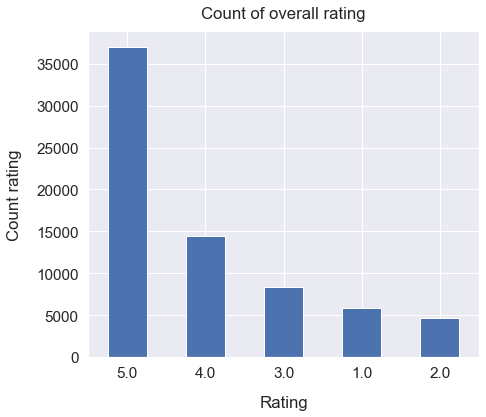

In [42]:
sns.set(font_scale=1.4)
df['overall'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Rating", labelpad=14)
plt.ylabel("Count rating", labelpad=14)
plt.title("Count of overall rating", y=1.02)

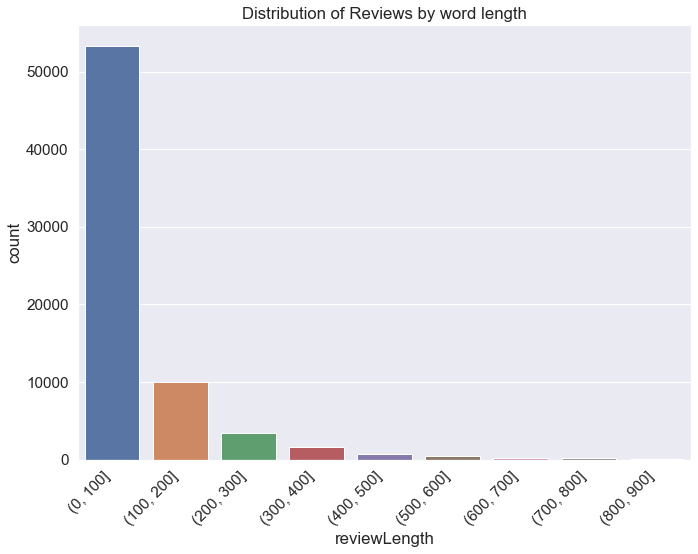

In [43]:
f,axes = plt.subplots(figsize=(10,8))
#---- Distribution of word reviews by length
appliances_reviews = df[["_id","asin_indexer","asin","overall","reviewText","reviewerID","reviewerID_indexer"]]
appliances_reviews['reviewLength'] = appliances_reviews['reviewText'].apply(lambda x: len(x.split()))

reviews_word_length = appliances_reviews.groupby(pd.cut(appliances_reviews.reviewLength, np.arange(0,1000,100))).count()
reviews_word_length = reviews_word_length.rename(columns={'reviewLength':'count'})
reviews_word_length = reviews_word_length.reset_index()

reviewLengthChart = sns.barplot(x='reviewLength',y='count',data=reviews_word_length, ax = axes)
reviewLengthChart.set_title('Distribution of Reviews by word length')
reviewLengthChart.set_xticklabels(reviewLengthChart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
f.tight_layout()

CPU times: total: 625 ms
Wall time: 631 ms


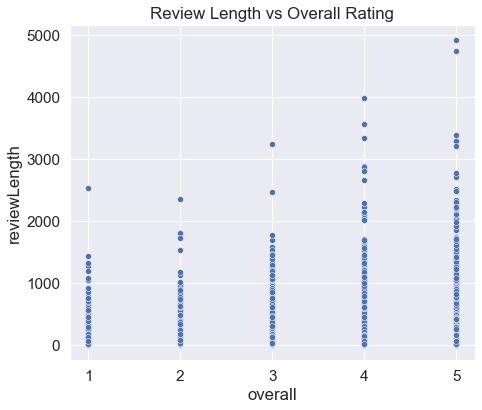

In [44]:
%%time
f, axes = plt.subplots(figsize=(7,6))
#--- Distribution of product Price vs overall Ratings of products by users
#--- got data of 63001 products
appliances_reviews = df[["_id","asin_indexer","asin","overall","reviewText","reviewerID","reviewerID_indexer"]]
appliances_reviews['reviewLength'] = appliances_reviews['reviewText'].apply(lambda x: len(x.split()))

#--- Distribution of length of reviews vs overall rating
reviewLength_vs_Rating = appliances_reviews[['asin','reviewLength','overall']]
reviewLength_vs_Rating = sns.scatterplot(x='overall', y='reviewLength', data=reviewLength_vs_Rating, ax = axes)
reviewLength_vs_Rating.set_title('Review Length vs Overall Rating')

f.tight_layout()

In [45]:
#--- HTML Tag Removal
import re #Regex (Regular Expr Operations)
#string = r"sdfsdfd" :- r is for raw string as Regex often uses \ backslashes(\w), so they are often raw strings(r’\d’)
########Function to remove html tags from data
def striphtml(data):
    p = re.compile('<.*?>')#Find this kind of pattern
    #print(p.findall(data))#List of strings which follow the regex pattern
    return p.sub('',data) #Substitute nothing at the place of strings which matched the patterns

striphtml('<a href="foo.com" class="bar">LG LED TV <b>This product is good!</b></a><>')

'LG LED TV This product is good!'

In [46]:
#--- Punctuation removal
########Function to remove All the punctuations from the text
def strippunc(data):
    p = re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return p.sub('',data)
strippunc("LG LED*?~,,,(TV)#")

'LG LEDTV'

In [47]:
#--- StopWords

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = stopwords.words('english') #All the stopwords in English language
#excluding some useful words from stop words list as we doing sentiment analysis
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',

In [48]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer
print("Stem/Root words of the some of the words using SnowBall Stemmer:")
print(snow.stem('tasty'))
print(snow.stem('tasteful'))
print(snow.stem('tastiest'))
print(snow.stem('delicious'))
print(snow.stem('amazing'))
print(snow.stem('amaze'))
print(snow.stem('initialize'))
print(snow.stem('fabulous'))
print(snow.stem('Honda City'))
print(snow.stem('unpleasant'))

Stem/Root words of the some of the words using SnowBall Stemmer:
tasti
tast
tastiest
delici
amaz
amaz
initi
fabul
honda c
unpleas


In [49]:
%%time
#pre-processing output for one Review
def preprocessText(text, stem=False):
  filtered_sentence = []
  final_string = []
  #print(text)
  text = striphtml(text) #--- remove HTML Tags
  text = strippunc(text) #--- remove Punctuation
  for w in text.split(): #--- isalpha() methods returns “True” if all characters in the string are alphabets, Otherwise, It returns “False”.
    if(w.isalpha() and (len(w) > 2)):  #--- Check is value is not numeric and has length > 2
      if(w.lower() not in stop):       #--- Check if it is a stopword
        if stem : 
          s = (snow.stem(w.lower())).encode('utf8') #--- Stemming the word using snowball stemmer
        else:
          s = (w.lower()).encode('utf8') #--- Stemming the word using snowball stemmer
        filtered_sentence.append(s)
      else:
        continue
    else:
      continue
  cleanedText = b" ".join(filtered_sentence) # string of cleaned words
  final_string.append(cleanedText)
  return final_string

print('---- Uncleaned Text ----')
print(df.reviewText[0])
print('---- Cleaned Text ----')
print(preprocessText(df.reviewText[0],True))
print()
print('---- Cleaned Text (without Stemming)----')
print(preprocessText(df.reviewText[0]))
print()

---- Uncleaned Text ----
I was initially leary about purchasing this item due to the extremely low price and to have free shipping also, but I needed a wall charger since Motorola only includes a car charger with their wireless car phone speakers.  So I took a chance (due to the low price and free shipping) and was pleasantly surprised.  The charger appears to as well made as the other after market chargers I purchased previously for my e-book reader, PDA, camera, etc., and at less than 25% of the cost.  I charged my Motorola speaker without any problems.
---- Cleaned Text ----
[b'initi leari purchas item due extrem low price free ship also need wall charger sinc motorola includ car charger wireless car phone speaker took chanc due low price free ship pleasant surpris charger appear well made market charger purchas previous reader pda camera etc less cost charg motorola speaker without problem']

---- Cleaned Text (without Stemming)----
[b'initially leary purchasing item due extremely 

In [50]:
#%%time
df['cleanedReview'] = df['reviewText'].map(preprocessText)
print("Preprocessing completed")
df.head()

Preprocessing completed


,_id,asin_indexer,asin,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview
0,632c18a9d66dc63db0a64b27,3187.0,9983798883,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...
1,632c18a9d66dc63db0a64b28,959.0,B0002HBOMO,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great']
2,632c18a9d66dc63db0a64b29,1178.0,B0006I2E1O,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0,[b'bought phone cingular service needed phone ...
3,632c18a9d66dc63db0a64b2a,1487.0,B0009RKGEO,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0,[b'bought usb data cable losing usb cable char...
4,632c18a9d66dc63db0a64b2b,3202.0,B0009W8DL2,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0,[b'works fine doesnt fits well ear']


In [51]:
df['binrating'] = df['overall'] >= 4
df.head()

,_id,asin_indexer,asin,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview,binrating
0,632c18a9d66dc63db0a64b27,3187.0,9983798883,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...,True
1,632c18a9d66dc63db0a64b28,959.0,B0002HBOMO,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great'],True
2,632c18a9d66dc63db0a64b29,1178.0,B0006I2E1O,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0,[b'bought phone cingular service needed phone ...,False
3,632c18a9d66dc63db0a64b2a,1487.0,B0009RKGEO,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0,[b'bought usb data cable losing usb cable char...,True
4,632c18a9d66dc63db0a64b2b,3202.0,B0009W8DL2,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0,[b'works fine doesnt fits well ear'],False


In [52]:
#---Function to calculate sentiments using Naive Bayes Analyzer
def NaiveBaiyes_Sentimental(sentence):
    blob = TextBlob(sentence, analyzer=NaiveBayesAnalyzer())
    NaiveBayes_SentimentScore=blob.sentiment.classification
    return NaiveBayes_SentimentScore

# VADER sentiment analysis tool for getting Compound score.
def sentimental(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    return score

# VADER sentiment analysis tool for getting pos, neg and neu.
def sentimental_Score(sentence):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(sentence)
    score=vs['compound']
    if score >= 0.5:
        return 'pos'
    elif (score > -0.5) and (score < 0.5):
        return 'neu'
    elif score <= -0.5:
        return 'neg'

In [53]:
#---- sample run on classifying the sentance
#sentence = 'there is no negative about this product It actually works with zero faults.' #---- Worst Case -- POS but Classified as NEG
sentence = 'this product is absolutely great.' #---- Best Case -- POS
#sentence = 'this product is absolutely great but with some faults.' #---- Best Case -- NEU
#sentence = 'this product actually works with zero faults.' #---- Worst Case -- POS but classified as NEG
sent = sentimental_Score(sentence)
print('The Sentence : \n',sentence)
print('The Sentence is of " ',sent,' " Sentiment.')

The Sentence : 
 this product is absolutely great.
The Sentence is of "  pos  " Sentiment.


In [54]:
#-- Not required to execute everytime
df['Sentiment_Score']=df['reviewText'].apply(lambda x: sentimental_Score(x))
df.head()

,_id,asin_indexer,asin,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview,binrating,Sentiment_Score
0,632c18a9d66dc63db0a64b27,3187.0,9983798883,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...,True,pos
1,632c18a9d66dc63db0a64b28,959.0,B0002HBOMO,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great'],True,pos
2,632c18a9d66dc63db0a64b29,1178.0,B0006I2E1O,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0,[b'bought phone cingular service needed phone ...,False,neu
3,632c18a9d66dc63db0a64b2a,1487.0,B0009RKGEO,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0,[b'bought usb data cable losing usb cable char...,True,neu
4,632c18a9d66dc63db0a64b2b,3202.0,B0009W8DL2,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0,[b'works fine doesnt fits well ear'],False,neu


In [55]:
#---save the files into data
df.to_pickle('Appliances_sentiment.pkl')

In [56]:
positive_data = df.loc[df['Sentiment_Score'] == 'pos']
negative_data = df.loc[df['Sentiment_Score'] == 'neg']
neutral_data = df.loc[df['Sentiment_Score'] == 'neu']

positive_data.to_pickle('positive_reviews.pkl')
negative_data.to_pickle('negative_reviews.pkl')
neutral_data.to_pickle('neutral_reviews.pkl')

In [57]:
%%time
sentimentAnalysisPath = "Appliances_sentiment.pkl"
PositiveReviewsPath = "positive_reviews.pkl"
NegativeReviewsPath = "negative_reviews.pkl"
NeutralReviewsPath = "neutral_reviews.pkl"

positive_data = pd.read_pickle(PositiveReviewsPath)
negative_data = pd.read_pickle(NegativeReviewsPath)
neutral_data = pd.read_pickle(NeutralReviewsPath)

CPU times: total: 500 ms
Wall time: 533 ms


In [58]:
positive_data.head()

,_id,asin_indexer,asin,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview,binrating,Sentiment_Score
0,632c18a9d66dc63db0a64b27,3187.0,9983798883,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...,True,pos
1,632c18a9d66dc63db0a64b28,959.0,B0002HBOMO,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great'],True,pos
6,632c18a9d66dc63db0a64b2d,1104.0,B000A1329U,5.0,"One person said in a review ""While this phone ...",A279FUL12R7MBD,5506.0,[b'one person said review phone thin bulky han...,True,pos
7,632c18a9d66dc63db0a64b2e,1260.0,B000EM2O2G,5.0,This case is mega study. I bought this because...,A21INUA35HX4XQ,1573.0,[b'case mega study bought kayaking dadthe case...,True,pos
8,632c18a9d66dc63db0a64b2f,196.0,B000GAO9T2,4.0,"The headset volume, size, comfort and ease of ...",A11JYON47SBFIK,12037.0,[b'headset volume size comfort ease wearing wo...,True,pos


In [59]:
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

In [60]:
df.head()

,_id,asin_indexer,asin,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview,binrating,Sentiment_Score
0,632c18a9d66dc63db0a64b27,3187.0,9983798883,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...,True,pos
1,632c18a9d66dc63db0a64b28,959.0,B0002HBOMO,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great'],True,pos
2,632c18a9d66dc63db0a64b29,1178.0,B0006I2E1O,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0,[b'bought phone cingular service needed phone ...,False,neu
3,632c18a9d66dc63db0a64b2a,1487.0,B0009RKGEO,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0,[b'bought usb data cable losing usb cable char...,True,neu
4,632c18a9d66dc63db0a64b2b,3202.0,B0009W8DL2,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0,[b'works fine doesnt fits well ear'],False,neu


In [61]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70312 entries, 0 to 70311
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   _id                 70312 non-null  object 
 1   asin_indexer        70312 non-null  float64
 2   asin                70312 non-null  object 
 3   overall             70312 non-null  float64
 4   reviewText          70312 non-null  object 
 5   reviewerID          70312 non-null  object 
 6   reviewerID_indexer  70312 non-null  float64
 7   cleanedReview       70312 non-null  object 
 8   binrating           70312 non-null  bool   
 9   Sentiment_Score     70312 non-null  object 
dtypes: bool(1), float64(3), object(6)
memory usage: 4.9+ MB


In [63]:
#--- WordCloud
'''from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=200, max_font_size=40, scale=3, random_state=1).generate(str(data)) 
    #chosen at random by flipping a coin; it was heads
show_wordcloud(df['cleanedReview'])
show_wordcloud(positive_data['cleanedReview'])
show_wordcloud(negative_data['cleanedReview'])
show_wordcloud(neutral_data['cleanedReview'])
print("Word Cloud processing completed")'''

'from wordcloud import WordCloud, STOPWORDS\nstopwords = set(STOPWORDS)\ndef show_wordcloud(data, title = None):\n    wordcloud = WordCloud(background_color=\'white\', stopwords=stopwords, max_words=200, max_font_size=40, scale=3, random_state=1).generate(str(data)) \n    #chosen at random by flipping a coin; it was heads\nshow_wordcloud(df[\'cleanedReview\'])\nshow_wordcloud(positive_data[\'cleanedReview\'])\nshow_wordcloud(negative_data[\'cleanedReview\'])\nshow_wordcloud(neutral_data[\'cleanedReview\'])\nprint("Word Cloud processing completed")'

In [64]:
dataset_cleaned = pd.read_pickle(sentimentAnalysisPath)
dataset_cleaned.head()

,_id,asin_indexer,asin,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview,binrating,Sentiment_Score
0,632c18a9d66dc63db0a64b27,3187.0,9983798883,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...,True,pos
1,632c18a9d66dc63db0a64b28,959.0,B0002HBOMO,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great'],True,pos
2,632c18a9d66dc63db0a64b29,1178.0,B0006I2E1O,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0,[b'bought phone cingular service needed phone ...,False,neu
3,632c18a9d66dc63db0a64b2a,1487.0,B0009RKGEO,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0,[b'bought usb data cable losing usb cable char...,True,neu
4,632c18a9d66dc63db0a64b2b,3202.0,B0009W8DL2,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0,[b'works fine doesnt fits well ear'],False,neu


In [65]:
#ignoring the reviews having overall score equal to 3. If the overall score is above 3, then the label for it will be set to Positive else it will be set to Negative
reviews = dataset_cleaned[dataset_cleaned['overall']!=3]
reviews = reviews[['overall']]
print('length of required data : ',len(reviews.overall))
reviews.groupby(['overall'])['overall'].count()

length of required data :  61998


overall
1.0     5891
2.0     4648
4.0    14425
5.0    37034
Name: overall, dtype: int64

In [66]:
reviews.head()

,overall
0,5.0
1,5.0
2,1.0
3,5.0
5,2.0


In [67]:
reviews["sentiment"] = reviews["overall"].apply(lambda score: "positive" if score > 3 else "negative")
reviews.head()

,overall,sentiment
0,5.0,positive
1,5.0,positive
2,1.0,negative
3,5.0,positive
5,2.0,negative


In [68]:
#!pip install spacy
import spacy

In [69]:
import itertools
import collections
Review_Clean = list(dataset_cleaned["cleanedReview"])
token_list = list(itertools.chain(*Review_Clean))
counts_no = collections.Counter(token_list)
clean_reviews = pd.DataFrame(counts_no.most_common(30),columns=['words','count'])

In [70]:
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

dataset_cleaned["Clean_reviewText"] = dataset_cleaned["reviewText"].apply(cleanReviews)

train, test = train_test_split(dataset_cleaned, test_size=0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))

56249 items in training data, 14063 in test data


In [71]:
dataset_cleaned.head()

,_id,asin_indexer,asin,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview,binrating,Sentiment_Score,Clean_reviewText
0,632c18a9d66dc63db0a64b27,3187.0,9983798883,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...,True,pos,i was initially leary about purchasing this it...
1,632c18a9d66dc63db0a64b28,959.0,B0002HBOMO,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great'],True,pos,works great
2,632c18a9d66dc63db0a64b29,1178.0,B0006I2E1O,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0,[b'bought phone cingular service needed phone ...,False,neu,bought this phone with cingular service i need...
3,632c18a9d66dc63db0a64b2a,1487.0,B0009RKGEO,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0,[b'bought usb data cable losing usb cable char...,True,neu,i bought this usb data cable after losing the ...
4,632c18a9d66dc63db0a64b2b,3202.0,B0009W8DL2,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0,[b'works fine doesnt fits well ear'],False,neu,it works fine but it doesn t fits tu well to t...


In [72]:
#Using TfidfTransformer().fit_transform to fit the train and test data
countVector = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = countVector.fit_transform(train["Clean_reviewText"])

#applying tfidf to term frequency
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = countVector.transform(test["Clean_reviewText"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["Sentiment_Score"]
y_test = test["Sentiment_Score"]

prediction = dict()

In [73]:
#We use below methods to classify the sentiment of the data.

#Multinomial Naïve Bayes learning method
#Logistic regression learning method

In [74]:
#--- Naive Bayes
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

In [75]:
#--- Logistic Regression
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

In [76]:
def testSentiments(model, testData):
    testCounts = countVector.transform([testData])
    testTfidf = tfidf_transformer.transform(testCounts)
    result = model.predict(testTfidf)[0]
    probability = model.predict_proba(testTfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), probability[0], probability[1]))

sentence1 = 'this product is absolutely great.' #---- Best Case -- POS
sentence3 = 'this product is absolutely great but with some faults.' #---- Best Case -- NEU
sentence2 = 'this product actually works with zero faults.' #---- Worst Case -- POS but classified as NEG
sentence4 = 'there is no negative about this product It actually works with zero faults.' #---- Worst Case -- POS but Classified as NEG


testSentiments(model, sentence1)
testSentiments(model, sentence2)
testSentiments(model, sentence3)
testSentiments(model, sentence4)

Sample estimated as POS: negative prob 0.003663, positive prob 0.039721
Sample estimated as POS: negative prob 0.007490, positive prob 0.091446
Sample estimated as POS: negative prob 0.003002, positive prob 0.040437
Sample estimated as POS: negative prob 0.000648, positive prob 0.020013


In [77]:
##Applying corpus

In [78]:
#Data Cleaning
# Cleaning the Text
import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [79]:
#jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10 - run in command prompt
corpus = []
for i in range(len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['reviewText'][i])
    review = review.lower()
    review = review.split()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not') 
    #remove negative word 'not' as it is closest word to help determine whether the review is good or not 
    review = [stemmer.stem(word) for word in review if not word in set(all_stopwords)]
    review = ' '.join(review)
    corpus.append(review)
#print(corpus)

In [80]:
from nltk.tokenize import word_tokenize

In [81]:
corpus_series = pd.Series(corpus,name="corpus_series")

In [82]:
reviews = pd.concat([df, corpus_series], axis=1)

In [83]:
reviews

,_id,asin_indexer,asin,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview,binrating,Sentiment_Score,corpus_series
0,632c18a9d66dc63db0a64b27,3187.0,9983798883,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...,True,pos,initi leari purchas item due extrem low price ...
1,632c18a9d66dc63db0a64b28,959.0,B0002HBOMO,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great'],True,pos,work great
2,632c18a9d66dc63db0a64b29,1178.0,B0006I2E1O,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0,[b'bought phone cingular service needed phone ...,False,neu,bought phone cingular servic need phone hurri ...
3,632c18a9d66dc63db0a64b2a,1487.0,B0009RKGEO,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0,[b'bought usb data cable losing usb cable char...,True,neu,bought usb data cabl lose usb cabl charg kiniv...
4,632c18a9d66dc63db0a64b2b,3202.0,B0009W8DL2,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0,[b'works fine doesnt fits well ear'],False,neu,work fine fit tu well ear
...,...,...,...,...,...,...,...,...,...,...,...
70307,632c18aad66dc63db0a75dca,1832.0,B006GHCJPK,2.0,I had this same ear piece in white and it came...,AHKTEI7V876RW,11392.0,[b'ear piece white came original box directors...,False,pos,ear piec white came origin box director ear at...
70308,632c18aad66dc63db0a75dcb,143.0,B006GZITVA,5.0,This case looks truly fabulous on the white ga...,A4JDZF0DOIKFS,21590.0,[b'case looks truly fabulous white galaxy note...,True,pos,case look truli fabul white galaxi note fit sn...
70309,632c18aad66dc63db0a75dcc,1633.0,B006IRPV9E,4.0,Very nice thin profile case for Samsung Galaxy...,A18ZPUZ5V0JFUV,17668.0,[b'nice thin profile case samsung galaxy note ...,True,pos,nice thin profil case samsung galaxi note colo...
70310,632c18aad66dc63db0a75dcd,1836.0,B006J1K3AG,5.0,Its the cutiest case ive ever had! &lt;3The on...,A2XBNQ3FFPE1PA,20124.0,[b'cutiest case ive ever one problem like many...,True,pos,cutiest case ive ever lt one problem like mani...


In [84]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
stop = stopwords.words('english')

In [86]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [87]:
reviews['corpus_series_without_stopwords'] = reviews["corpus_series"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [88]:
reviews

,_id,asin_indexer,asin,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview,binrating,Sentiment_Score,corpus_series,corpus_series_without_stopwords
0,632c18a9d66dc63db0a64b27,3187.0,9983798883,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...,True,pos,initi leari purchas item due extrem low price ...,initi leari purchas item due extrem low price ...
1,632c18a9d66dc63db0a64b28,959.0,B0002HBOMO,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great'],True,pos,work great,work great
2,632c18a9d66dc63db0a64b29,1178.0,B0006I2E1O,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0,[b'bought phone cingular service needed phone ...,False,neu,bought phone cingular servic need phone hurri ...,bought phone cingular servic need phone hurri ...
3,632c18a9d66dc63db0a64b2a,1487.0,B0009RKGEO,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0,[b'bought usb data cable losing usb cable char...,True,neu,bought usb data cabl lose usb cabl charg kiniv...,bought usb data cabl lose usb cabl charg kiniv...
4,632c18a9d66dc63db0a64b2b,3202.0,B0009W8DL2,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0,[b'works fine doesnt fits well ear'],False,neu,work fine fit tu well ear,work fine fit tu well ear
...,...,...,...,...,...,...,...,...,...,...,...,...
70307,632c18aad66dc63db0a75dca,1832.0,B006GHCJPK,2.0,I had this same ear piece in white and it came...,AHKTEI7V876RW,11392.0,[b'ear piece white came original box directors...,False,pos,ear piec white came origin box director ear at...,ear piec white came origin box director ear at...
70308,632c18aad66dc63db0a75dcb,143.0,B006GZITVA,5.0,This case looks truly fabulous on the white ga...,A4JDZF0DOIKFS,21590.0,[b'case looks truly fabulous white galaxy note...,True,pos,case look truli fabul white galaxi note fit sn...,case look truli fabul white galaxi note fit sn...
70309,632c18aad66dc63db0a75dcc,1633.0,B006IRPV9E,4.0,Very nice thin profile case for Samsung Galaxy...,A18ZPUZ5V0JFUV,17668.0,[b'nice thin profile case samsung galaxy note ...,True,pos,nice thin profil case samsung galaxi note colo...,nice thin profil case samsung galaxi note colo...
70310,632c18aad66dc63db0a75dcd,1836.0,B006J1K3AG,5.0,Its the cutiest case ive ever had! &lt;3The on...,A2XBNQ3FFPE1PA,20124.0,[b'cutiest case ive ever one problem like many...,True,pos,cutiest case ive ever lt one problem like mani...,cutiest case ive ever lt one problem like mani...


In [89]:
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [90]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [91]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
reviews['Review_Clean'] = (reviews['corpus_series_without_stopwords'].apply(lemmatize_text))

In [92]:
reviews['Review_Clean_String'] = [' '.join(map(str, l)) for l in reviews['Review_Clean']]

In [93]:
reviews

,_id,asin_indexer,asin,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview,binrating,Sentiment_Score,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String
0,632c18a9d66dc63db0a64b27,3187.0,9983798883,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...,True,pos,initi leari purchas item due extrem low price ...,initi leari purchas item due extrem low price ...,"[initi, leari, purchas, item, due, extrem, low...",initi leari purchas item due extrem low price ...
1,632c18a9d66dc63db0a64b28,959.0,B0002HBOMO,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great'],True,pos,work great,work great,"[work, great]",work great
2,632c18a9d66dc63db0a64b29,1178.0,B0006I2E1O,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0,[b'bought phone cingular service needed phone ...,False,neu,bought phone cingular servic need phone hurri ...,bought phone cingular servic need phone hurri ...,"[bought, phone, cingular, servic, need, phone,...",bought phone cingular servic need phone hurri ...
3,632c18a9d66dc63db0a64b2a,1487.0,B0009RKGEO,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0,[b'bought usb data cable losing usb cable char...,True,neu,bought usb data cabl lose usb cabl charg kiniv...,bought usb data cabl lose usb cabl charg kiniv...,"[bought, usb, data, cabl, lose, usb, cabl, cha...",bought usb data cabl lose usb cabl charg kiniv...
4,632c18a9d66dc63db0a64b2b,3202.0,B0009W8DL2,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0,[b'works fine doesnt fits well ear'],False,neu,work fine fit tu well ear,work fine fit tu well ear,"[work, fine, fit, tu, well, ear]",work fine fit tu well ear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70307,632c18aad66dc63db0a75dca,1832.0,B006GHCJPK,2.0,I had this same ear piece in white and it came...,AHKTEI7V876RW,11392.0,[b'ear piece white came original box directors...,False,pos,ear piec white came origin box director ear at...,ear piec white came origin box director ear at...,"[ear, piec, white, came, origin, box, director...",ear piec white came origin box director ear at...
70308,632c18aad66dc63db0a75dcb,143.0,B006GZITVA,5.0,This case looks truly fabulous on the white ga...,A4JDZF0DOIKFS,21590.0,[b'case looks truly fabulous white galaxy note...,True,pos,case look truli fabul white galaxi note fit sn...,case look truli fabul white galaxi note fit sn...,"[case, look, truli, fabul, white, galaxi, note...",case look truli fabul white galaxi note fit sn...
70309,632c18aad66dc63db0a75dcc,1633.0,B006IRPV9E,4.0,Very nice thin profile case for Samsung Galaxy...,A18ZPUZ5V0JFUV,17668.0,[b'nice thin profile case samsung galaxy note ...,True,pos,nice thin profil case samsung galaxi note colo...,nice thin profil case samsung galaxi note colo...,"[nice, thin, profil, case, samsung, galaxi, no...",nice thin profil case samsung galaxi note colo...
70310,632c18aad66dc63db0a75dcd,1836.0,B006J1K3AG,5.0,Its the cutiest case ive ever had! &lt;3The on...,A2XBNQ3FFPE1PA,20124.0,[b'cutiest case ive ever one problem like many...,True,pos,cutiest case ive ever lt one problem like mani...,cutiest case ive ever lt one problem like mani...,"[cutiest, case, ive, ever, lt, one, problem, l...",cutiest case ive ever lt one problem like mani...


In [94]:
from wordcloud import WordCloud, STOPWORDS

In [95]:
import spacy

In [96]:
import itertools
import collections
Review_Clean = list(reviews["Review_Clean"])
token_list = list(itertools.chain(*Review_Clean))
counts_no = collections.Counter(token_list)
clean_reviews = pd.DataFrame(counts_no.most_common(30),columns=['words','count'])

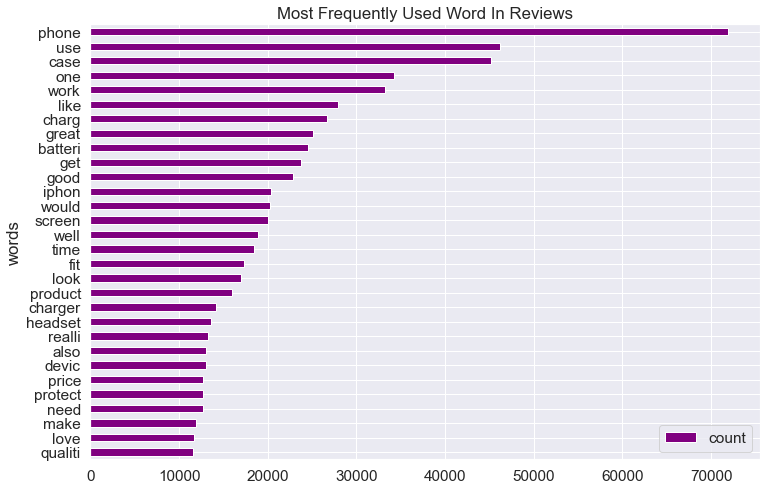

In [97]:
fig ,ax=plt.subplots(figsize=(12,8))
clean_reviews.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="purple")
ax.set_title("Most Frequently Used Word In Reviews")
plt.show()

In [98]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [99]:
res = {}
for i, row in tqdm(reviews.iterrows(), total=len(reviews)):
    text = row['Review_Clean_String']
    myid = row['asin']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/70312 [00:00<?, ?it/s]

In [100]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'asin'})
vaders = vaders.merge(reviews, how='right')

In [101]:
vaders

,asin,neg,neu,pos,compound,_id,asin_indexer,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview,binrating,Sentiment_Score,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String
0,9983798883,0.000,0.745,0.255,0.6249,632c18a9d66dc63db0a64b27,3187.0,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...,True,pos,initi leari purchas item due extrem low price ...,initi leari purchas item due extrem low price ...,"[initi, leari, purchas, item, due, extrem, low...",initi leari purchas item due extrem low price ...
1,B0002HBOMO,0.000,0.760,0.240,0.6249,632c18a9d66dc63db0a64b28,959.0,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great'],True,pos,work great,work great,"[work, great]",work great
2,B0006I2E1O,0.000,0.703,0.297,0.8271,632c18a9d66dc63db0a64b29,1178.0,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0,[b'bought phone cingular service needed phone ...,False,neu,bought phone cingular servic need phone hurri ...,bought phone cingular servic need phone hurri ...,"[bought, phone, cingular, servic, need, phone,...",bought phone cingular servic need phone hurri ...
3,B0009RKGEO,0.022,0.894,0.084,0.7579,632c18a9d66dc63db0a64b2a,1487.0,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0,[b'bought usb data cable losing usb cable char...,True,neu,bought usb data cabl lose usb cabl charg kiniv...,bought usb data cabl lose usb cabl charg kiniv...,"[bought, usb, data, cabl, lose, usb, cabl, cha...",bought usb data cabl lose usb cabl charg kiniv...
4,B0009W8DL2,0.022,0.823,0.155,0.9786,632c18a9d66dc63db0a64b2b,3202.0,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0,[b'works fine doesnt fits well ear'],False,neu,work fine fit tu well ear,work fine fit tu well ear,"[work, fine, fit, tu, well, ear]",work fine fit tu well ear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70307,B006GHCJPK,0.049,0.759,0.192,0.7783,632c18aad66dc63db0a75dca,1832.0,2.0,I had this same ear piece in white and it came...,AHKTEI7V876RW,11392.0,[b'ear piece white came original box directors...,False,pos,ear piec white came origin box director ear at...,ear piec white came origin box director ear at...,"[ear, piec, white, came, origin, box, director...",ear piec white came origin box director ear at...
70308,B006GZITVA,0.057,0.710,0.232,0.9382,632c18aad66dc63db0a75dcb,143.0,5.0,This case looks truly fabulous on the white ga...,A4JDZF0DOIKFS,21590.0,[b'case looks truly fabulous white galaxy note...,True,pos,case look truli fabul white galaxi note fit sn...,case look truli fabul white galaxi note fit sn...,"[case, look, truli, fabul, white, galaxi, note...",case look truli fabul white galaxi note fit sn...
70309,B006IRPV9E,0.133,0.590,0.277,0.6808,632c18aad66dc63db0a75dcc,1633.0,4.0,Very nice thin profile case for Samsung Galaxy...,A18ZPUZ5V0JFUV,17668.0,[b'nice thin profile case samsung galaxy note ...,True,pos,nice thin profil case samsung galaxi note colo...,nice thin profil case samsung galaxi note colo...,"[nice, thin, profil, case, samsung, galaxi, no...",nice thin profil case samsung galaxi note colo...
70310,B006J1K3AG,0.071,0.794,0.135,0.3400,632c18aad66dc63db0a75dcd,1836.0,5.0,Its the cutiest case ive ever had! &lt;3The on...,A2XBNQ3FFPE1PA,20124.0,[b'cutiest case ive ever one problem like many...,True,pos,cutiest case ive ever lt one problem like mani...,cutiest case ive ever lt one problem like mani...,"[cutiest, case, ive, ever, lt, one, problem, l...",cutiest case ive ever lt one problem like mani...


In [102]:
def find_polarity(rev):
    return TextBlob(rev).sentiment.polarity

In [103]:
vaders["polarity"]=vaders["Review_Clean_String"].apply(find_polarity)

In [104]:
for i in range(0,len(vaders["reviewText"])):
            print(vaders["polarity"][i])

0.054761904761904776
0.8
0.23888888888888887
0.1
0.4083333333333333
0.37222222222222223
0.19577352472089316
0.24395604395604395
0.65
0.3303030303030303
0.37222222222222223
0.10833333333333336
0.09999999999999999
0.44999999999999996
0.6999999999999998
0.37777777777777777
-0.04999999999999993
0.32222222222222224
-0.1333333333333333
0.0
0.1357142857142857
0.07203856749311295
0.21515151515151512
0.15000000000000002
0.10625
0.15196969696969698
0.16515873015873017
0.03888888888888888
0.2958333333333333
0.25
-0.15
0.17692307692307693
0.09922003284072248
-0.1015873015873016
0.037500000000000006
0.4766666666666667
0.4
0.2271921341070278
0.5583333333333333
0.0
0.6
0.29166666666666663
0.4
0.4444444444444444
0.8
0.3833333333333333
0.8
0.0
-0.013888888888888895
0.4611111111111112
0.008541666666666666
0.2
0.38055555555555554
0.14411764705882354
0.3666666666666667
0.06979166666666667
0.1902777777777778
0.17777777777777778
0.5833333333333334
0.3888888888888889
0.5
0.22499999999999998
0.245238095238095

In [105]:
vaders

,asin,neg,neu,pos,compound,_id,asin_indexer,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview,binrating,Sentiment_Score,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String,polarity
0,9983798883,0.000,0.745,0.255,0.6249,632c18a9d66dc63db0a64b27,3187.0,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...,True,pos,initi leari purchas item due extrem low price ...,initi leari purchas item due extrem low price ...,"[initi, leari, purchas, item, due, extrem, low...",initi leari purchas item due extrem low price ...,0.054762
1,B0002HBOMO,0.000,0.760,0.240,0.6249,632c18a9d66dc63db0a64b28,959.0,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great'],True,pos,work great,work great,"[work, great]",work great,0.800000
2,B0006I2E1O,0.000,0.703,0.297,0.8271,632c18a9d66dc63db0a64b29,1178.0,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0,[b'bought phone cingular service needed phone ...,False,neu,bought phone cingular servic need phone hurri ...,bought phone cingular servic need phone hurri ...,"[bought, phone, cingular, servic, need, phone,...",bought phone cingular servic need phone hurri ...,0.238889
3,B0009RKGEO,0.022,0.894,0.084,0.7579,632c18a9d66dc63db0a64b2a,1487.0,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0,[b'bought usb data cable losing usb cable char...,True,neu,bought usb data cabl lose usb cabl charg kiniv...,bought usb data cabl lose usb cabl charg kiniv...,"[bought, usb, data, cabl, lose, usb, cabl, cha...",bought usb data cabl lose usb cabl charg kiniv...,0.100000
4,B0009W8DL2,0.022,0.823,0.155,0.9786,632c18a9d66dc63db0a64b2b,3202.0,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0,[b'works fine doesnt fits well ear'],False,neu,work fine fit tu well ear,work fine fit tu well ear,"[work, fine, fit, tu, well, ear]",work fine fit tu well ear,0.408333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70307,B006GHCJPK,0.049,0.759,0.192,0.7783,632c18aad66dc63db0a75dca,1832.0,2.0,I had this same ear piece in white and it came...,AHKTEI7V876RW,11392.0,[b'ear piece white came original box directors...,False,pos,ear piec white came origin box director ear at...,ear piec white came origin box director ear at...,"[ear, piec, white, came, origin, box, director...",ear piec white came origin box director ear at...,0.166667
70308,B006GZITVA,0.057,0.710,0.232,0.9382,632c18aad66dc63db0a75dcb,143.0,5.0,This case looks truly fabulous on the white ga...,A4JDZF0DOIKFS,21590.0,[b'case looks truly fabulous white galaxy note...,True,pos,case look truli fabul white galaxi note fit sn...,case look truli fabul white galaxi note fit sn...,"[case, look, truli, fabul, white, galaxi, note...",case look truli fabul white galaxi note fit sn...,0.196825
70309,B006IRPV9E,0.133,0.590,0.277,0.6808,632c18aad66dc63db0a75dcc,1633.0,4.0,Very nice thin profile case for Samsung Galaxy...,A18ZPUZ5V0JFUV,17668.0,[b'nice thin profile case samsung galaxy note ...,True,pos,nice thin profil case samsung galaxi note colo...,nice thin profil case samsung galaxi note colo...,"[nice, thin, profil, case, samsung, galaxi, no...",nice thin profil case samsung galaxi note colo...,0.114286
70310,B006J1K3AG,0.071,0.794,0.135,0.3400,632c18aad66dc63db0a75dcd,1836.0,5.0,Its the cutiest case ive ever had! &lt;3The on...,A2XBNQ3FFPE1PA,20124.0,[b'cutiest case ive ever one problem like many...,True,pos,cutiest case ive ever lt one problem like mani...,cutiest case ive ever lt one problem like mani...,"[cutiest, case, ive, ever, lt, one, problem, l...",cutiest case ive ever lt one problem like mani...,0.350000


In [106]:
vaders["classification"] = vaders["polarity"].apply(lambda x: "Positive" if x > 0 else "Negative")

In [107]:
vaders

,asin,neg,neu,pos,compound,_id,asin_indexer,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview,binrating,Sentiment_Score,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String,polarity,classification
0,9983798883,0.000,0.745,0.255,0.6249,632c18a9d66dc63db0a64b27,3187.0,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...,True,pos,initi leari purchas item due extrem low price ...,initi leari purchas item due extrem low price ...,"[initi, leari, purchas, item, due, extrem, low...",initi leari purchas item due extrem low price ...,0.054762,Positive
1,B0002HBOMO,0.000,0.760,0.240,0.6249,632c18a9d66dc63db0a64b28,959.0,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great'],True,pos,work great,work great,"[work, great]",work great,0.800000,Positive
2,B0006I2E1O,0.000,0.703,0.297,0.8271,632c18a9d66dc63db0a64b29,1178.0,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0,[b'bought phone cingular service needed phone ...,False,neu,bought phone cingular servic need phone hurri ...,bought phone cingular servic need phone hurri ...,"[bought, phone, cingular, servic, need, phone,...",bought phone cingular servic need phone hurri ...,0.238889,Positive
3,B0009RKGEO,0.022,0.894,0.084,0.7579,632c18a9d66dc63db0a64b2a,1487.0,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0,[b'bought usb data cable losing usb cable char...,True,neu,bought usb data cabl lose usb cabl charg kiniv...,bought usb data cabl lose usb cabl charg kiniv...,"[bought, usb, data, cabl, lose, usb, cabl, cha...",bought usb data cabl lose usb cabl charg kiniv...,0.100000,Positive
4,B0009W8DL2,0.022,0.823,0.155,0.9786,632c18a9d66dc63db0a64b2b,3202.0,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0,[b'works fine doesnt fits well ear'],False,neu,work fine fit tu well ear,work fine fit tu well ear,"[work, fine, fit, tu, well, ear]",work fine fit tu well ear,0.408333,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70307,B006GHCJPK,0.049,0.759,0.192,0.7783,632c18aad66dc63db0a75dca,1832.0,2.0,I had this same ear piece in white and it came...,AHKTEI7V876RW,11392.0,[b'ear piece white came original box directors...,False,pos,ear piec white came origin box director ear at...,ear piec white came origin box director ear at...,"[ear, piec, white, came, origin, box, director...",ear piec white came origin box director ear at...,0.166667,Positive
70308,B006GZITVA,0.057,0.710,0.232,0.9382,632c18aad66dc63db0a75dcb,143.0,5.0,This case looks truly fabulous on the white ga...,A4JDZF0DOIKFS,21590.0,[b'case looks truly fabulous white galaxy note...,True,pos,case look truli fabul white galaxi note fit sn...,case look truli fabul white galaxi note fit sn...,"[case, look, truli, fabul, white, galaxi, note...",case look truli fabul white galaxi note fit sn...,0.196825,Positive
70309,B006IRPV9E,0.133,0.590,0.277,0.6808,632c18aad66dc63db0a75dcc,1633.0,4.0,Very nice thin profile case for Samsung Galaxy...,A18ZPUZ5V0JFUV,17668.0,[b'nice thin profile case samsung galaxy note ...,True,pos,nice thin profil case samsung galaxi note colo...,nice thin profil case samsung galaxi note colo...,"[nice, thin, profil, case, samsung, galaxi, no...",nice thin profil case samsung galaxi note colo...,0.114286,Positive
70310,B006J1K3AG,0.071,0.794,0.135,0.3400,632c18aad66dc63db0a75dcd,1836.0,5.0,Its the cutiest case ive ever had! &lt;3The on...,A2XBNQ3FFPE1PA,20124.0,[b'cutiest case ive ever one problem like many...,True,pos,cutiest case ive ever lt one problem like mani...,cutiest case ive ever lt one problem like mani...,"[cutiest, case, ive, ever, lt, one, problem, l...",cutiest case ive ever lt one problem like mani...,0.350000,Positive


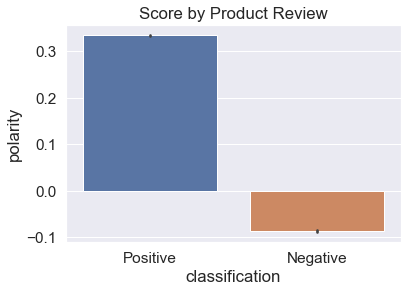

In [108]:
ax = sns.barplot(data=vaders, x='classification', y='polarity')
ax.set_title('Score by Product Review')
plt.show()

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [110]:
tfidf_converter = TfidfVectorizer(max_features=2000)
features = tfidf_converter.fit_transform(vaders['Review_Clean_String']).toarray()

In [111]:
#!pip install lightgbm
#!pip install scikit-learn

In [112]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
target = vaders['classification']
x_train , x_test ,y_train ,y_test = train_test_split(features,target,test_size=0.3)
clf = lgb.LGBMClassifier(max_depth=20,
                        n_estimators=25,
                        min_child_weights=0.0016,
                        n_jobs=-1)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Test data Accuracy is:",accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

[LightGBM] [Warning] Unknown parameter: min_child_weights
Test data Accuracy is: 0.9435384469517398
              precision    recall  f1-score   support

    Negative       0.86      0.79      0.82      3445
    Positive       0.96      0.97      0.97     17649

    accuracy                           0.94     21094
   macro avg       0.91      0.88      0.89     21094
weighted avg       0.94      0.94      0.94     21094



<AxesSubplot:>

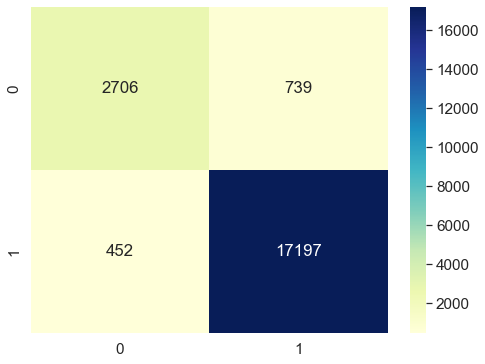

In [113]:
cm = confusion_matrix(y_test,pred)

fig,ax= plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True ,fmt ='d',cmap = 'YlGnBu')

In [114]:
vaders["nb_words"] = vaders["Review_Clean_String"].apply(lambda x: len(x.split(" ")))

In [115]:
vaders[vaders["nb_words"]>= 5].sort_values("polarity", ascending = False)[["Review_Clean_String","classification"]].head(100)

,Review_Clean_String,classification
7303,happi function way make easi charg phone drop ...,Positive
45456,best screen cover easi appli wife iphon galaxi...,Positive
23312,probabl best case month search case offer prot...,Positive
48692,perfect replac tray iphon origin piec issu rec...,Positive
19697,one best phone screen protector occasion side ...,Positive
...,...,...
18065,reason give star automat connect phone get car...,Positive
53145,use armorsuit one best screen protector easi i...,Positive
20702,greatest batteri ever evo extend life batter job,Positive
25558,mayb best qualiti product suppos realli need,Positive


In [116]:
vaders[vaders["nb_words"] >= 5].sort_values("polarity", ascending = True)[["Review_Clean_String","classification"]].head(10)

,Review_Clean_String,classification
47694,appl product dock well manufactur sadli charge...,Negative
52363,worst phone ever would never ever buy even pho...,Negative
7547,one worst bluetooth thought tri price say goe ...,Negative
18087,absolut worst case purchas yet even opportun p...,Negative
28787,never kept iphon stand worst stand ever purcha...,Negative
65015,day got sleep wake button fell case order ton ...,Negative
66060,husband select cover rubberi offer excel drop ...,Negative
21943,worst screen protector ever bought hardest eve...,Negative
32886,worst case ever got wont stay cant hold sholde...,Negative
7872,bought worst product ever use work advertis no...,Negative


In [117]:
vaders

,asin,neg,neu,pos,compound,_id,asin_indexer,overall,reviewText,reviewerID,...,cleanedReview,binrating,Sentiment_Score,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String,polarity,classification,nb_words
0,9983798883,0.000,0.745,0.255,0.6249,632c18a9d66dc63db0a64b27,3187.0,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,...,[b'initially leary purchasing item due extreme...,True,pos,initi leari purchas item due extrem low price ...,initi leari purchas item due extrem low price ...,"[initi, leari, purchas, item, due, extrem, low...",initi leari purchas item due extrem low price ...,0.054762,Positive,53
1,B0002HBOMO,0.000,0.760,0.240,0.6249,632c18a9d66dc63db0a64b28,959.0,5.0,works great,A3IYRM3X94M3OC,...,[b'works great'],True,pos,work great,work great,"[work, great]",work great,0.800000,Positive,2
2,B0006I2E1O,0.000,0.703,0.297,0.8271,632c18a9d66dc63db0a64b29,1178.0,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,...,[b'bought phone cingular service needed phone ...,False,neu,bought phone cingular servic need phone hurri ...,bought phone cingular servic need phone hurri ...,"[bought, phone, cingular, servic, need, phone,...",bought phone cingular servic need phone hurri ...,0.238889,Positive,121
3,B0009RKGEO,0.022,0.894,0.084,0.7579,632c18a9d66dc63db0a64b2a,1487.0,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,...,[b'bought usb data cable losing usb cable char...,True,neu,bought usb data cabl lose usb cabl charg kiniv...,bought usb data cabl lose usb cabl charg kiniv...,"[bought, usb, data, cabl, lose, usb, cabl, cha...",bought usb data cabl lose usb cabl charg kiniv...,0.100000,Positive,18
4,B0009W8DL2,0.022,0.823,0.155,0.9786,632c18a9d66dc63db0a64b2b,3202.0,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,...,[b'works fine doesnt fits well ear'],False,neu,work fine fit tu well ear,work fine fit tu well ear,"[work, fine, fit, tu, well, ear]",work fine fit tu well ear,0.408333,Positive,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70307,B006GHCJPK,0.049,0.759,0.192,0.7783,632c18aad66dc63db0a75dca,1832.0,2.0,I had this same ear piece in white and it came...,AHKTEI7V876RW,...,[b'ear piece white came original box directors...,False,pos,ear piec white came origin box director ear at...,ear piec white came origin box director ear at...,"[ear, piec, white, came, origin, box, director...",ear piec white came origin box director ear at...,0.166667,Positive,40
70308,B006GZITVA,0.057,0.710,0.232,0.9382,632c18aad66dc63db0a75dcb,143.0,5.0,This case looks truly fabulous on the white ga...,A4JDZF0DOIKFS,...,[b'case looks truly fabulous white galaxy note...,True,pos,case look truli fabul white galaxi note fit sn...,case look truli fabul white galaxi note fit sn...,"[case, look, truli, fabul, white, galaxi, note...",case look truli fabul white galaxi note fit sn...,0.196825,Positive,72
70309,B006IRPV9E,0.133,0.590,0.277,0.6808,632c18aad66dc63db0a75dcc,1633.0,4.0,Very nice thin profile case for Samsung Galaxy...,A18ZPUZ5V0JFUV,...,[b'nice thin profile case samsung galaxy note ...,True,pos,nice thin profil case samsung galaxi note colo...,nice thin profil case samsung galaxi note colo...,"[nice, thin, profil, case, samsung, galaxi, no...",nice thin profil case samsung galaxi note colo...,0.114286,Positive,29
70310,B006J1K3AG,0.071,0.794,0.135,0.3400,632c18aad66dc63db0a75dcd,1836.0,5.0,Its the cutiest case ive ever had! &lt;3The on...,A2XBNQ3FFPE1PA,...,[b'cutiest case ive ever one problem like many...,True,pos,cutiest case ive ever lt one problem like mani...,cutiest case ive ever lt one problem like mani...,"[cutiest, case, ive, ever, lt, one, problem, l...",cutiest case ive ever lt one problem like mani...,0.350000,Positive,33


In [118]:
file_name = 'SentimentClassification.xlsx'
vaders.to_excel(file_name)
print('DataFrame is written to Excel File successfully.')

DataFrame is written to Excel File successfully.


In [119]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(vaders['Review_Clean_String']).toarray()
y = vaders['classification']

In [120]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [121]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=12)
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

[0.97760239 0.97482935 0.97333618 0.97312287 0.97440273 0.97461063
 0.97567741 0.97162364 0.97866439 0.97567741 0.97546405 0.971837  ]
97.47373356533076
The accuracy of the Logistic Regression is 97.19832183744577


<AxesSubplot:>

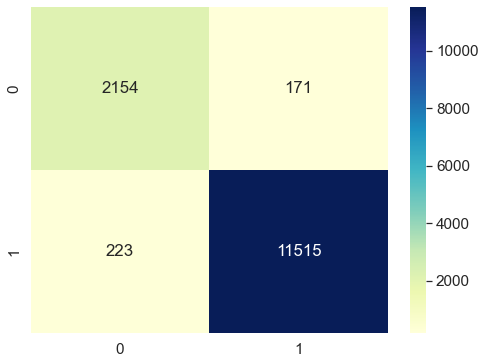

In [122]:
#logistic regression
lr = LogisticRegression(random_state=0, C=0.82286, max_iter=2000, solver='lbfgs')
cv = cross_val_score(lr,X_train,y_train,cv=kfold)
print(cv)
print(cv.mean()*100)
lr.fit(X_train,y_train)
y_pred_lr=lr.predict(X_test)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(y_pred_lr,y_test)*100)
cm=confusion_matrix(y_test, y_pred_lr)
#print(cm)

fig,ax= plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True ,fmt ='d',cmap = 'YlGnBu')

[0.28946246 0.29970137 0.29223549 0.29308874 0.2883959  0.29635161
 0.28056326 0.29272456 0.28205675 0.29144442 0.28504374 0.29336463]
29.03694103556105
The accuracy of the Naive Bayes is 29.054966934508997


<AxesSubplot:>

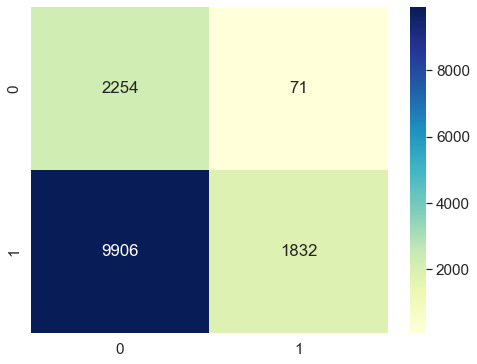

In [123]:
#GaussianNB
gnb = GaussianNB(var_smoothing=1e-2)
cv = cross_val_score(gnb,X_train,y_train,cv=kfold)
print(cv)
print(cv.mean()*100)
gnb.fit(X_train,y_train)
y_pred_gnb=gnb.predict(X_test)
print('The accuracy of the Naive Bayes is', metrics.accuracy_score(y_pred_gnb,y_test)*100)
cm=confusion_matrix(y_test, y_pred_gnb)
#print(cm)

fig,ax= plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True ,fmt ='d',cmap = 'YlGnBu')

[0.86369454 0.84492321 0.85964164 0.84897611 0.85025597 0.85363772
 0.86281203 0.8512908  0.85598464 0.8527843  0.84382334 0.85619799]
85.36685247943325
The accuracy of the Naive Bayes is 85.42985138306194


<AxesSubplot:>

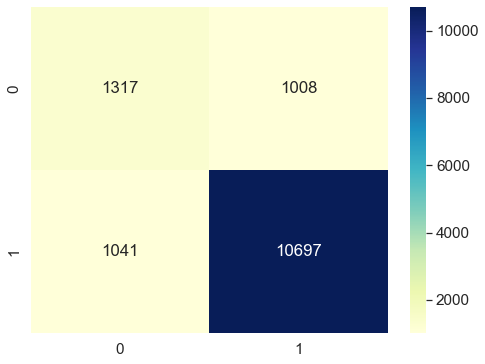

In [124]:
#MultinomialNB
mnb = MultinomialNB(alpha=2)
cv = cross_val_score(mnb,X_train,y_train,cv=kfold)
print(cv)
print(cv.mean()*100)
mnb.fit(X_train,y_train)
y_pred_mnb=mnb.predict(X_test)
print('The accuracy of the Naive Bayes is', metrics.accuracy_score(y_pred_mnb,y_test)*100)
cm=confusion_matrix(y_test, y_pred_mnb)
#print(cm)

fig,ax= plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True ,fmt ='d',cmap = 'YlGnBu')

[0.58575085 0.59492321 0.59577645 0.59343003 0.59151024 0.6005974
 0.58523576 0.59078302 0.59334329 0.59419671 0.59995733 0.61510561]
59.50508251407264
The accuracy of the Naive Bayes is 59.80942899808007


<AxesSubplot:>

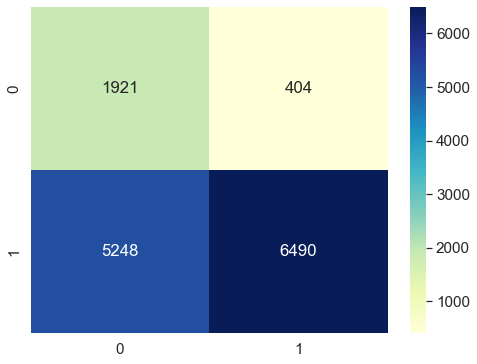

In [125]:
#Bernoulli NB
bnb = BernoulliNB(alpha=10)
cv = cross_val_score(bnb,X_train,y_train,cv=kfold)
print(cv)
print(cv.mean()*100)
bnb.fit(X_train,y_train)
y_pred_bnb=bnb.predict(X_test)
print('The accuracy of the Naive Bayes is', metrics.accuracy_score(y_pred_bnb,y_test)*100)
cm=confusion_matrix(y_test, y_pred_bnb)
#print(cm)

fig,ax= plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True ,fmt ='d',cmap = 'YlGnBu')

[0.83553754 0.83553754 0.83553754 0.83553754 0.83553754 0.83571581
 0.83571581 0.83550245 0.83550245 0.83550245 0.83550245 0.83550245]
83.55526333882136
The accuracy of the RandomForestClassifier is 83.48147621417905


<AxesSubplot:>

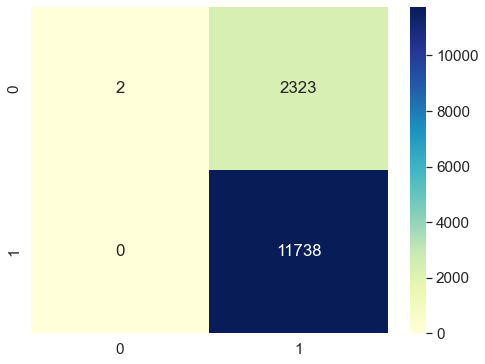

In [126]:
#Random Forest Classifier
rf = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=30,
                       max_features='log2', min_samples_leaf=2,
                       n_estimators=10, random_state=0)
rf.fit(X_train, y_train)
cv = cross_val_score(rf,X_train,y_train,cv=kfold)
print(cv)
print(cv.mean()*100)
y_pred_rf = rf.predict(X_test)
print('The accuracy of the RandomForestClassifier is',metrics.accuracy_score(y_pred_rf,y_test)*100)
cm=confusion_matrix(y_test, y_pred_rf)
#print(cm)

fig,ax= plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True ,fmt ='d',cmap = 'YlGnBu')

In [127]:
df_meta = spark.read.json('D:\\CDAC_Documents\\CDAC_Modules\\Project DBDA\\newDF\\Meta_Cell_Phone_Accessories.json')

In [128]:
df1 = df_meta.drop(*('similar_item','price','rank','also_buy','also_view','date','details','description','feature','fit','imageURL','imageURLHighRes','tech1','tech2'))
df1.show()

+----------+--------------------+--------------------+--------------------+--------------------+
|      asin|               brand|            category|            main_cat|               title|
+----------+--------------------+--------------------+--------------------+--------------------+
|6303195164|                    |[Cell Phones & Ac...|         Movies & TV|Trollies Sing a L...|
|630524412X|     Maribel Guardia|[Cell Phones & Ac...|         Movies & TV|         La Pura VHS|
|6310200240|                    |[Cell Phones & Ac...|               Books|Leopard Thanksgiv...|
|6786501710|          Live2Pedal|[Cell Phones & Ac...|Cell Phones & Acc...|Puppies Faceplate...|
|6786501273|   wirelessoutletusa|[Cell Phones & Ac...|Cell Phones & Acc...|White Wolf Facepl...|
|6789300104|   wirelessoutletusa|[Cell Phones & Ac...|Cell Phones & Acc...|Camo Duck Grass R...|
|6786501052|             Samsung|[Cell Phones & Ac...|Cell Phones & Acc...|Camoflague Camo U...|
|7030131746|            Motoro

In [135]:
# using select function applying
# explode on array column

df_meta_f = df1.select(df1.asin,df1.brand,df1.main_cat,df1.title,explode(df1.category))
 
# printing the schema of the df2
df_meta_f.printSchema()
 
# show df2
df_meta_f.show()

root
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- main_cat: string (nullable = true)
 |-- title: string (nullable = true)
 |-- col: string (nullable = true)

+----------+-----------------+--------------------+--------------------+--------------------+
|      asin|            brand|            main_cat|               title|                 col|
+----------+-----------------+--------------------+--------------------+--------------------+
|6303195164|                 |         Movies & TV|Trollies Sing a L...|Cell Phones & Acc...|
|6303195164|                 |         Movies & TV|Trollies Sing a L...|         Accessories|
|6303195164|                 |         Movies & TV|Trollies Sing a L...|   Screen Protectors|
|630524412X|  Maribel Guardia|         Movies & TV|         La Pura VHS|Cell Phones & Acc...|
|630524412X|  Maribel Guardia|         Movies & TV|         La Pura VHS|         Accessories|
|630524412X|  Maribel Guardia|         Movies & TV|      

In [136]:
#### Drop rows with conditions – where clause
df_meta_f.printSchema()
from pyspark.sql.functions import length
df_meta_f1=df_meta_f.where(length("brand")>0)

root
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- main_cat: string (nullable = true)
 |-- title: string (nullable = true)
 |-- col: string (nullable = true)



In [137]:
#check null values 
checkNullValues = {col:df_meta_f1.filter(df_meta_f1[col].isNull()).count() for col in df_meta_f1.columns}
print(checkNullValues)
print(df_meta_f1.count())

'''checkNullValues = {col:df1.filter(df1[col].isNull()).count() for col in df1.columns}
print(checkNullValues)'''

{'asin': 0, 'brand': 0, 'main_cat': 0, 'title': 0, 'col': 0}
24510


'checkNullValues = {col:df1.filter(df1[col].isNull()).count() for col in df1.columns}\nprint(checkNullValues)'

In [138]:
df_meta = df_meta_f1.dropDuplicates()
print(df_meta.count())
df_meta.show(truncate=True)

22736
+----------+--------------------+--------------------+--------------------+--------------------+
|      asin|               brand|            main_cat|               title|                 col|
+----------+--------------------+--------------------+--------------------+--------------------+
|630524412X|     Maribel Guardia|         Movies & TV|         La Pura VHS|     Car Accessories|
|7562015902|         edealsaving|Cell Phones & Acc...|Full Diamond Pink...|Cell Phones & Acc...|
|8288836925|             Samsung|Cell Phones & Acc...|Samsung Official ...|Chargers & Power ...|
|9612909598|  Wireless Solutions|Cell Phones & Acc...|Slim Line Microma...|         Accessories|
|9712932125|            SlimPort|Cell Phones & Acc...|SlimPort Adapter ...|              Cables|
|9831311671|      Factory Direct|Cell Phones & Acc...|Professional Quic...|       Wall Chargers|
|9831986814|                 HTC|Cell Phones & Acc...|Rapid 1.5A Charge...|         Accessories|
|9861025251|     Handhel

In [139]:
#dump the cleaned meta dataframe in mongodb sentiment analysis 
ml = spark.read.format("mongo").option("uri","mongodb://localhost:27017/Cleaned_MB_Meta_Acc6.MB_Meta_Acc").load()
df_meta.write.format("mongo").option("uri","mongodb://localhost:27017/Cleaned_MB_Meta_Acc6.MB_Meta_Acc").save()

In [140]:
client = MongoClient('localhost',27017)
db = client.Cleaned_MB_Meta_Acc6
data = db.MB_Meta_Acc
df_meta = pd.DataFrame(list(data.find()))
df_meta.head()

,_id,asin,brand,main_cat,title,col
0,632c2768d66dc63db0a8c956,630524412X,Maribel Guardia,Movies & TV,La Pura VHS,Car Accessories
1,632c2768d66dc63db0a8c957,7562015902,edealsaving,Cell Phones & Accessories,Full Diamond Pink Black Star Snap on Design Ca...,Cell Phones & Accessories
2,632c2768d66dc63db0a8c958,8288836925,Samsung,Cell Phones & Accessories,Samsung Official OEM Travel Wall Charger for y...,Chargers & Power Adapters
3,632c2768d66dc63db0a8c959,9612909598,Wireless Solutions,Cell Phones & Accessories,Slim Line Micromax X226 Plus Smartphone Portab...,Accessories
4,632c2768d66dc63db0a8c95a,9712932125,SlimPort,Cell Phones & Accessories,SlimPort Adapter for BlackBerry Passport Smart...,Cables


In [141]:
df_meta.drop(['_id'], axis=1)

,asin,brand,main_cat,title,col
0,630524412X,Maribel Guardia,Movies & TV,La Pura VHS,Car Accessories
1,7562015902,edealsaving,Cell Phones & Accessories,Full Diamond Pink Black Star Snap on Design Ca...,Cell Phones & Accessories
2,8288836925,Samsung,Cell Phones & Accessories,Samsung Official OEM Travel Wall Charger for y...,Chargers & Power Adapters
3,9612909598,Wireless Solutions,Cell Phones & Accessories,Slim Line Micromax X226 Plus Smartphone Portab...,Accessories
4,9712932125,SlimPort,Cell Phones & Accessories,SlimPort Adapter for BlackBerry Passport Smart...,Cables
...,...,...,...,...,...
22731,B0016830JI,Verizon,Cell Phones & Accessories,Case for LG Fits VX8350,Cell Phones & Accessories
22732,B001685J06,LorAnn Oils,Amazon Home,Root Beer Flavor 1 dram Twin Pack,Car Chargers
22733,B0016H8YN6,Looking Deals,Cell Phones & Accessories,SOLID Black SNAP-ON COVER HARD CASE PHONE PROT...,Cell Phones & Accessories
22734,B0016XIQ74,Wagan,Automotive,Wagan EL2444 Bluetooth Portable Hands-Free Car...,Accessories


In [142]:
vaders.head()

,asin,neg,neu,pos,compound,_id,asin_indexer,overall,reviewText,reviewerID,...,cleanedReview,binrating,Sentiment_Score,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String,polarity,classification,nb_words
0,9983798883,0.000,0.745,0.255,0.6249,632c18a9d66dc63db0a64b27,3187.0,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,...,[b'initially leary purchasing item due extreme...,True,pos,initi leari purchas item due extrem low price ...,initi leari purchas item due extrem low price ...,"[initi, leari, purchas, item, due, extrem, low...",initi leari purchas item due extrem low price ...,0.054762,Positive,53
1,B0002HBOMO,0.000,0.760,0.240,0.6249,632c18a9d66dc63db0a64b28,959.0,5.0,works great,A3IYRM3X94M3OC,...,[b'works great'],True,pos,work great,work great,"[work, great]",work great,0.800000,Positive,2
2,B0006I2E1O,0.000,0.703,0.297,0.8271,632c18a9d66dc63db0a64b29,1178.0,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,...,[b'bought phone cingular service needed phone ...,False,neu,bought phone cingular servic need phone hurri ...,bought phone cingular servic need phone hurri ...,"[bought, phone, cingular, servic, need, phone,...",bought phone cingular servic need phone hurri ...,0.238889,Positive,121
3,B0009RKGEO,0.022,0.894,0.084,0.7579,632c18a9d66dc63db0a64b2a,1487.0,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,...,[b'bought usb data cable losing usb cable char...,True,neu,bought usb data cabl lose usb cabl charg kiniv...,bought usb data cabl lose usb cabl charg kiniv...,"[bought, usb, data, cabl, lose, usb, cabl, cha...",bought usb data cabl lose usb cabl charg kiniv...,0.100000,Positive,18
4,B0009W8DL2,0.022,0.823,0.155,0.9786,632c18a9d66dc63db0a64b2b,3202.0,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,...,[b'works fine doesnt fits well ear'],False,neu,work fine fit tu well ear,work fine fit tu well ear,"[work, fine, fit, tu, well, ear]",work fine fit tu well ear,0.408333,Positive,6


In [143]:
vaders.drop(["_id"],axis=1)
#df_meta.drop(["_id"],axis=1)

,asin,neg,neu,pos,compound,asin_indexer,overall,reviewText,reviewerID,reviewerID_indexer,cleanedReview,binrating,Sentiment_Score,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String,polarity,classification,nb_words
0,9983798883,0.000,0.745,0.255,0.6249,3187.0,5.0,I was initially leary about purchasing this it...,A20LIRO8WUETPH,13385.0,[b'initially leary purchasing item due extreme...,True,pos,initi leari purchas item due extrem low price ...,initi leari purchas item due extrem low price ...,"[initi, leari, purchas, item, due, extrem, low...",initi leari purchas item due extrem low price ...,0.054762,Positive,53
1,B0002HBOMO,0.000,0.760,0.240,0.6249,959.0,5.0,works great,A3IYRM3X94M3OC,15537.0,[b'works great'],True,pos,work great,work great,"[work, great]",work great,0.800000,Positive,2
2,B0006I2E1O,0.000,0.703,0.297,0.8271,1178.0,1.0,Bought this phone with Cingular service. I nee...,A2FTIE6F5IQUR0,5714.0,[b'bought phone cingular service needed phone ...,False,neu,bought phone cingular servic need phone hurri ...,bought phone cingular servic need phone hurri ...,"[bought, phone, cingular, servic, need, phone,...",bought phone cingular servic need phone hurri ...,0.238889,Positive,121
3,B0009RKGEO,0.022,0.894,0.084,0.7579,1487.0,5.0,I bought this usb data cable after losing the ...,A3PP8GIB3JJ03U,10717.0,[b'bought usb data cable losing usb cable char...,True,neu,bought usb data cabl lose usb cabl charg kiniv...,bought usb data cabl lose usb cabl charg kiniv...,"[bought, usb, data, cabl, lose, usb, cabl, cha...",bought usb data cabl lose usb cabl charg kiniv...,0.100000,Positive,18
4,B0009W8DL2,0.022,0.823,0.155,0.9786,3202.0,3.0,IT works fine but it doesn't fits tu well to t...,ATWM509SVUWZS,11767.0,[b'works fine doesnt fits well ear'],False,neu,work fine fit tu well ear,work fine fit tu well ear,"[work, fine, fit, tu, well, ear]",work fine fit tu well ear,0.408333,Positive,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70307,B006GHCJPK,0.049,0.759,0.192,0.7783,1832.0,2.0,I had this same ear piece in white and it came...,AHKTEI7V876RW,11392.0,[b'ear piece white came original box directors...,False,pos,ear piec white came origin box director ear at...,ear piec white came origin box director ear at...,"[ear, piec, white, came, origin, box, director...",ear piec white came origin box director ear at...,0.166667,Positive,40
70308,B006GZITVA,0.057,0.710,0.232,0.9382,143.0,5.0,This case looks truly fabulous on the white ga...,A4JDZF0DOIKFS,21590.0,[b'case looks truly fabulous white galaxy note...,True,pos,case look truli fabul white galaxi note fit sn...,case look truli fabul white galaxi note fit sn...,"[case, look, truli, fabul, white, galaxi, note...",case look truli fabul white galaxi note fit sn...,0.196825,Positive,72
70309,B006IRPV9E,0.133,0.590,0.277,0.6808,1633.0,4.0,Very nice thin profile case for Samsung Galaxy...,A18ZPUZ5V0JFUV,17668.0,[b'nice thin profile case samsung galaxy note ...,True,pos,nice thin profil case samsung galaxi note colo...,nice thin profil case samsung galaxi note colo...,"[nice, thin, profil, case, samsung, galaxi, no...",nice thin profil case samsung galaxi note colo...,0.114286,Positive,29
70310,B006J1K3AG,0.071,0.794,0.135,0.3400,1836.0,5.0,Its the cutiest case ive ever had! &lt;3The on...,A2XBNQ3FFPE1PA,20124.0,[b'cutiest case ive ever one problem like many...,True,pos,cutiest case ive ever lt one problem like mani...,cutiest case ive ever lt one problem like mani...,"[cutiest, case, ive, ever, lt, one, problem, l...",cutiest case ive ever lt one problem like mani...,0.350000,Positive,33


In [144]:
'''merged_dataframe = pd.merge(vaders, df_meta, left_index=True, right_index=True,how='inner')'''
merged_dataframe = pd.merge(vaders, df_meta,how='inner', on = 'asin')

In [145]:
merged_dataframe.head()

,asin,neg,neu,pos,compound,_id_x,asin_indexer,overall,reviewText,reviewerID,...,Review_Clean,Review_Clean_String,polarity,classification,nb_words,_id_y,brand,main_cat,title,col
0,B000A1329U,0.078,0.703,0.219,0.9903,632c18a9d66dc63db0a64b2d,1104.0,5.0,"One person said in a review ""While this phone ...",A279FUL12R7MBD,...,"[one, person, said, review, phone, thin, bulki...",one person said review phone thin bulki handl ...,0.195774,Positive,143,632c2768d66dc63db0a8dca9,Motorola,Cell Phones & Accessories,Motorola RAZR V3 Black (AT&amp;T),Cell Phones
1,B000A1329U,0.078,0.703,0.219,0.9903,632c18a9d66dc63db0a64b2d,1104.0,5.0,"One person said in a review ""While this phone ...",A279FUL12R7MBD,...,"[one, person, said, review, phone, thin, bulki...",one person said review phone thin bulki handl ...,0.195774,Positive,143,632c2768d66dc63db0a8e5c6,Motorola,Cell Phones & Accessories,Motorola RAZR V3 Black (AT&amp;T),Cell Phones & Accessories
2,B000A1329U,0.078,0.703,0.219,0.9903,632c18a9d66dc63db0a64b2d,1104.0,5.0,"One person said in a review ""While this phone ...",A279FUL12R7MBD,...,"[one, person, said, review, phone, thin, bulki...",one person said review phone thin bulki handl ...,0.195774,Positive,143,632c2768d66dc63db0a900e7,Motorola,Cell Phones & Accessories,Motorola RAZR V3 Black (AT&amp;T),Unlocked Cell Phones
3,B000A1329U,0.078,0.703,0.219,0.9903,632c18a9d66dc63db0a65423,1104.0,5.0,Oct 7th 2005If you look carefully at these so ...,AVK9BSXJJ51I8,...,"[oct, th, look, care, call, bad, review, notic...",oct th look care call bad review notic either ...,0.204653,Positive,692,632c2768d66dc63db0a8dca9,Motorola,Cell Phones & Accessories,Motorola RAZR V3 Black (AT&amp;T),Cell Phones
4,B000A1329U,0.078,0.703,0.219,0.9903,632c18a9d66dc63db0a65423,1104.0,5.0,Oct 7th 2005If you look carefully at these so ...,AVK9BSXJJ51I8,...,"[oct, th, look, care, call, bad, review, notic...",oct th look care call bad review notic either ...,0.204653,Positive,692,632c2768d66dc63db0a8e5c6,Motorola,Cell Phones & Accessories,Motorola RAZR V3 Black (AT&amp;T),Cell Phones & Accessories


In [146]:
merged_dataframe.drop(["_id_y","_id_x"],axis=1)

,asin,neg,neu,pos,compound,asin_indexer,overall,reviewText,reviewerID,reviewerID_indexer,...,corpus_series_without_stopwords,Review_Clean,Review_Clean_String,polarity,classification,nb_words,brand,main_cat,title,col
0,B000A1329U,0.078,0.703,0.219,0.9903,1104.0,5.0,"One person said in a review ""While this phone ...",A279FUL12R7MBD,5506.0,...,one person said review phone thin bulki handl ...,"[one, person, said, review, phone, thin, bulki...",one person said review phone thin bulki handl ...,0.195774,Positive,143,Motorola,Cell Phones & Accessories,Motorola RAZR V3 Black (AT&amp;T),Cell Phones
1,B000A1329U,0.078,0.703,0.219,0.9903,1104.0,5.0,"One person said in a review ""While this phone ...",A279FUL12R7MBD,5506.0,...,one person said review phone thin bulki handl ...,"[one, person, said, review, phone, thin, bulki...",one person said review phone thin bulki handl ...,0.195774,Positive,143,Motorola,Cell Phones & Accessories,Motorola RAZR V3 Black (AT&amp;T),Cell Phones & Accessories
2,B000A1329U,0.078,0.703,0.219,0.9903,1104.0,5.0,"One person said in a review ""While this phone ...",A279FUL12R7MBD,5506.0,...,one person said review phone thin bulki handl ...,"[one, person, said, review, phone, thin, bulki...",one person said review phone thin bulki handl ...,0.195774,Positive,143,Motorola,Cell Phones & Accessories,Motorola RAZR V3 Black (AT&amp;T),Unlocked Cell Phones
3,B000A1329U,0.078,0.703,0.219,0.9903,1104.0,5.0,Oct 7th 2005If you look carefully at these so ...,AVK9BSXJJ51I8,1283.0,...,oct th look care call bad review notic either ...,"[oct, th, look, care, call, bad, review, notic...",oct th look care call bad review notic either ...,0.204653,Positive,692,Motorola,Cell Phones & Accessories,Motorola RAZR V3 Black (AT&amp;T),Cell Phones
4,B000A1329U,0.078,0.703,0.219,0.9903,1104.0,5.0,Oct 7th 2005If you look carefully at these so ...,AVK9BSXJJ51I8,1283.0,...,oct th look care call bad review notic either ...,"[oct, th, look, care, call, bad, review, notic...",oct th look care call bad review notic either ...,0.204653,Positive,692,Motorola,Cell Phones & Accessories,Motorola RAZR V3 Black (AT&amp;T),Cell Phones & Accessories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4529,B0000DYUZO,0.036,0.667,0.297,0.9451,2710.0,5.0,I got this otterbox to hold my valuables at th...,A2VSNUK7YLRKRE,1810.0,...,got otterbox hold valuabl pool summer perfect ...,"[got, otterbox, hold, valuabl, pool, summer, p...",got otterbox hold valuabl pool summer perfect ...,1.000000,Positive,26,OtterBox,Cell Phones & Accessories,Otter Box 3000 Series Case,Cell Phones & Accessories
4530,B0000DYUZO,0.036,0.667,0.297,0.9451,2710.0,3.0,The product is okay but could be better. The f...,A36R0XYHEWP2LA,15073.0,...,product okay could better first problem one la...,"[product, okay, could, better, first, problem,...",product okay could better first problem one la...,0.088333,Positive,130,OtterBox,Cell Phones & Accessories,Otter Box 3000 Series Case,"Cases, Holsters & Sleeves"
4531,B0000DYUZO,0.036,0.667,0.297,0.9451,2710.0,3.0,The product is okay but could be better. The f...,A36R0XYHEWP2LA,15073.0,...,product okay could better first problem one la...,"[product, okay, could, better, first, problem,...",product okay could better first problem one la...,0.088333,Positive,130,OtterBox,Cell Phones & Accessories,Otter Box 3000 Series Case,Cell Phones & Accessories
4532,B0000DYUZO,0.036,0.667,0.297,0.9451,2710.0,4.0,This case works great! My wife and I are takin...,A1ZU55TM45Y2R8,24.0,...,case work great wife take kayak need way prote...,"[case, work, great, wife, take, kayak, need, w...",case work great wife take kayak need way prote...,0.453810,Positive,52,OtterBox,Cell Phones & Accessories,Otter Box 3000 Series Case,"Cases, Holsters & Sleeves"


In [147]:
r=merged_dataframe.shape[0]
print(r)

4534


In [148]:
file_name = 'Sentiment_class_category.xlsx'
merged_dataframe.to_excel(file_name)
print('DataFrame is written to Excel File successfully.')

DataFrame is written to Excel File successfully.


In [ ]:
import pandas as pd
import pymongo
from pymongo import MongoClient

In [ ]:
# Making a Connection with MongoClient
client = MongoClient("mongodb://localhost:27018/")
# database
db = client["Mobile_Accessories"]
# collection
company= db["MB_ACC_Data"]

In [ ]:
# Imports
import pandas as pd
from pymongo import MongoClient

# Connect to MongoDB
client =  MongoClient('localhost',27017)
db = client['Project']
collection = db['Final_MB_ACC']
#merged_dataframe.reset_index()
data_dict = merged_dataframe.to_dict("records")
# Insert collection
collection.insert_many(data_dict)

In [155]:
rec_1=merged_dataframe.copy(deep=True)

In [156]:
rec_1.head(1)

,asin,neg,neu,pos,compound,_id_x,asin_indexer,overall,reviewText,reviewerID,...,Review_Clean,Review_Clean_String,polarity,classification,nb_words,_id_y,brand,main_cat,title,col
0,B000A1329U,0.078,0.703,0.219,0.9903,632c18a9d66dc63db0a64b2d,1104.0,5.0,"One person said in a review ""While this phone ...",A279FUL12R7MBD,...,"[one, person, said, review, phone, thin, bulki...",one person said review phone thin bulki handl ...,0.195774,Positive,143,632c2768d66dc63db0a8dca9,Motorola,Cell Phones & Accessories,Motorola RAZR V3 Black (AT&amp;T),Cell Phones


In [157]:
rec_2 = rec_1.drop(['neg','neu','pos',"compound",'reviewerID_indexer','cleanedReview','binrating','binrating','Sentiment_Score','corpus_series','corpus_series_without_stopwords','_id_x','overall','reviewerID','reviewText','Review_Clean_String','polarity','classification','nb_words','_id_y'],axis=1)

In [158]:
rec_2.head(1)

,asin,asin_indexer,Review_Clean,brand,main_cat,title,col
0,B000A1329U,1104.0,"[one, person, said, review, phone, thin, bulki...",Motorola,Cell Phones & Accessories,Motorola RAZR V3 Black (AT&amp;T),Cell Phones


In [159]:
rec_2.isnull().sum()

asin            0
asin_indexer    0
Review_Clean    0
brand           0
main_cat        0
title           0
col             0
dtype: int64

In [160]:
rec_2.dropna(inplace=True)

In [165]:
type(rec_2)

pandas.core.frame.DataFrame

In [168]:
rec_2.head(1)

,asin,asin_indexer,Review_Clean,brand,main_cat,title,col
0,B000A1329U,1104.0,"[one, person, said, review, phone, thin, bulki...",Motorola,Cell Phones & Accessories,Motorola RAZR V3 Black (AT&amp;T),Cell Phones


In [171]:
rec_2['title'] = rec_2['title'].map(lambda x: x.strip('\(AT&amp;T\)'))

In [174]:
rec_2['title'][1111]

'New Trent: iTorch 5200mAh Ultra Portable USB Port External Battery Charger/Power Pack for Smartphones and more (w/built-in laser + flashlight'

In [182]:
rec_2['brand'] = rec_2['brand'].map(lambda x: x.replace(' ',''))

In [183]:
rec_2['brand'][111]

'BoxWaveCorporation'

In [184]:
rec_2['main_cat'] = rec_2['main_cat'].map(lambda x: x.replace(' ',''))

In [185]:
rec_2['main_cat'][0]

'CellPhones&Accessories'

In [186]:
rec_2['col'] = rec_2['col'].map(lambda x: x.append(' ',''))

In [193]:
rec_2['col'][4532]

'Cases,Holsters&Sleeves'

In [188]:
rec_2.head(1)

,asin,asin_indexer,Review_Clean,brand,main_cat,title,col
0,B000A1329U,1104.0,"[one, person, said, review, phone, thin, bulki...",Motorola,CellPhones&Accessories,Motorola RAZR V3 Black,CellPhones


In [194]:
rec_2['col'] = rec_2['col'].map(lambda x: x.split(','))
#rec_2['col'].map(lambda x: x.strip(''))

In [197]:
rec_2['brand'] = rec_2['brand'].map(lambda x: x.split(' '))

In [198]:
rec_2['main_cat'] = rec_2['main_cat'].map(lambda x: x.split(' '))

In [199]:
rec_2.head(1)

,asin,asin_indexer,Review_Clean,brand,main_cat,title,col
0,B000A1329U,1104.0,"[one, person, said, review, phone, thin, bulki...",[Motorola],[CellPhones&Accessories],Motorola RAZR V3 Black,[CellPhones]


In [200]:
rec_2["tags"] = rec_2['Review_Clean']+rec_2['main_cat']+rec_2['col']+rec_2['brand']

In [201]:
rec_2.head(1)

,asin,asin_indexer,Review_Clean,brand,main_cat,title,col,tags
0,B000A1329U,1104.0,"[one, person, said, review, phone, thin, bulki...",[Motorola],[CellPhones&Accessories],Motorola RAZR V3 Black,[CellPhones],"[one, person, said, review, phone, thin, bulki..."


In [314]:
new_df = rec_2[['asin','asin_indexer','title','tags']]

In [315]:
new_df.head()

,asin,asin_indexer,title,tags
0,B000A1329U,1104.0,Motorola RAZR V3 Black,"[one, person, said, review, phone, thin, bulki..."
1,B000A1329U,1104.0,Motorola RAZR V3 Black,"[one, person, said, review, phone, thin, bulki..."
2,B000A1329U,1104.0,Motorola RAZR V3 Black,"[one, person, said, review, phone, thin, bulki..."
3,B000A1329U,1104.0,Motorola RAZR V3 Black,"[oct, th, look, care, call, bad, review, notic..."
4,B000A1329U,1104.0,Motorola RAZR V3 Black,"[oct, th, look, care, call, bad, review, notic..."


In [316]:
new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))
new_df.head()

,asin,asin_indexer,title,tags
0,B000A1329U,1104.0,Motorola RAZR V3 Black,one person said review phone thin bulki handl ...
1,B000A1329U,1104.0,Motorola RAZR V3 Black,one person said review phone thin bulki handl ...
2,B000A1329U,1104.0,Motorola RAZR V3 Black,one person said review phone thin bulki handl ...
3,B000A1329U,1104.0,Motorola RAZR V3 Black,oct th look care call bad review notic either ...
4,B000A1329U,1104.0,Motorola RAZR V3 Black,oct th look care call bad review notic either ...


In [317]:
new_df['tags'][0]

'one person said review phone thin bulki handl seem flimsi could disagre feel extremli sturdi tini phone thin weigh would expect mind feel bit well made version motorola v well year got free gave friend need phone badli cingular custom want new phone anyway work well got nokia one two week ago say good deal price like return got razr spent bit razr reason razor simpl phone good phone come pretti case make happi everi time open good qualiti camera digit camera like good qualiti web cam find easi read dial everyth clear space nicley got black version nick name kit night rider car remind yeah dork read complaint phone come enough stuff well launch price point would say yeah overpr come good deal book plea far plea enough come write review also love cool accessori get includ vynl sp skin color want CellPhones&Accessories CellPhones Motorola'

In [371]:
new_df['tags'] = new_df['tags'].apply(lambda x:x.lower())
new_df.head()

,asin,asin_indexer,title,tags
0,B000A1329U,1104.0,Motorola RAZR V3 Black,one person said review phone thin bulki handl ...
1,B000A1329U,1104.0,Motorola RAZR V3 Black,one person said review phone thin bulki handl ...
2,B000A1329U,1104.0,Motorola RAZR V3 Black,one person said review phone thin bulki handl ...
3,B000A1329U,1104.0,Motorola RAZR V3 Black,oct th look care call bad review notic either ...
4,B000A1329U,1104.0,Motorola RAZR V3 Black,oct th look care call bad review notic either ...


In [372]:
new_df

,asin,asin_indexer,title,tags
0,B000A1329U,1104.0,Motorola RAZR V3 Black,one person said review phone thin bulki handl ...
1,B000A1329U,1104.0,Motorola RAZR V3 Black,one person said review phone thin bulki handl ...
2,B000A1329U,1104.0,Motorola RAZR V3 Black,one person said review phone thin bulki handl ...
3,B000A1329U,1104.0,Motorola RAZR V3 Black,oct th look care call bad review notic either ...
4,B000A1329U,1104.0,Motorola RAZR V3 Black,oct th look care call bad review notic either ...
...,...,...,...,...
4529,B0000DYUZO,2710.0,Otter Box 3000 Series Case,got otterbox hold valuabl pool summer perfect ...
4530,B0000DYUZO,2710.0,Otter Box 3000 Series Case,product okay could better first problem one la...
4531,B0000DYUZO,2710.0,Otter Box 3000 Series Case,product okay could better first problem one la...
4532,B0000DYUZO,2710.0,Otter Box 3000 Series Case,case work great wife take kayak need way prote...


In [373]:
new_df1 = new_df.drop_duplicates(subset='title')

In [389]:
new_df1 = new_df1.reset_index(drop=True)

In [390]:
new_df1.shape[0]

112

In [391]:
new_df1

,asin,asin_indexer,title,tags
0,B000A1329U,1104.0,Motorola RAZR V3 Black,one person said review phone thin bulki handl ...
1,B000EM2O2G,1260.0,OtterBox 2000-20 WaterProof Universal Case - B...,case mega studi bought go kayak dad case big e...
2,B000IEDI66,249.0,"Galaxy S4 Case, BoxWave&reg; [Arctic Frost Cry...",beauti design case provid great tpu protect wi...
3,B000KNJEV8,704.0,Cellet universal car vent or dash mount phone ...,impress super cheap fit loo car air vent wiggl...
4,B0011WFERU,2094.0,Insten Deluxe Adjustable Black Armband Sports ...,bad obvious low qualiti strap adjust wide rang...
...,...,...,...,...
107,B0011GI94Q,3258.0,weBoost 3G Wireless Cellular Phone Signal Boos...,product great littl pricey well worth money wo...
108,B000XQGJUG,3253.0,Jabra SP5050 Bt Speakerphone (Discontinued by ...,two one wife passat tundra limit truck great o...
109,B000XOK9VS,3252.0,Sena UltraSlim Pouch for iPhone and iPhone 3G/...,sena case year iphon g sinc aug phone case exc...
110,9983744066,2709.0,Palm PRE Charging USB 2.0 Data Cable for your ...,good inexpens cabl work like origin purchas ca...


In [392]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,stop_words='english')

In [393]:
vector = cv.fit_transform(new_df1['tags']).toarray()

In [394]:
cv.get_feature_names()

['aa',
 'abil',
 'abilit',
 'abl',
 'abroad',
 'absolut',
 'ac',
 'accept',
 'access',
 'accessori',
 'accessories',
 'accessorykits',
 'accident',
 'accommod',
 'accompani',
 'account',
 'accur',
 'act',
 'activ',
 'actual',
 'ad',
 'adapt',
 'adaptor',
 'adaystech',
 'add',
 'addit',
 'addon',
 'address',
 'adema',
 'adequ',
 'adhes',
 'adjust',
 'advantag',
 'advertis',
 'advic',
 'aesthet',
 'afford',
 'aftermarket',
 'age',
 'ago',
 'ahead',
 'aim',
 'air',
 'aircard',
 'airplan',
 'airport',
 'alert',
 'alik',
 'aliv',
 'allelectronics',
 'allow',
 'alreadi',
 'alreadyi',
 'aluminum',
 'alway',
 'amaz',
 'amazingli',
 'amazon',
 'amazondevices',
 'american',
 'amp',
 'amplifi',
 'analog',
 'angel',
 'annoy',
 'anoth',
 'answer',
 'ant',
 'antenna',
 'anti',
 'anymor',
 'anyon',
 'anyth',
 'anywher',
 'apart',
 'app',
 'appar',
 'appear',
 'appl',
 'appli',
 'applic',
 'applicationsth',
 'appreci',
 'appropri',
 'archiv',
 'area',
 'arkon',
 'arm',
 'armbands',
 'array',
 'arriv',

In [395]:
import nltk
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [396]:
def stem(text):
    y = []
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)


In [397]:
new_df1["tags"].apply(stem)

0      one person said review phone thin bulki handl ...
1      case mega studi bought go kayak dad case big e...
2      beauti design case provid great tpu protect wi...
3      impress super cheap fit loo car air vent wiggl...
4      bad obviou low qualiti strap adjust wide rang ...
                             ...                        
107    product great littl pricey well worth money wo...
108    two one wife passat tundra limit truck great o...
109    sena case year iphon g sinc aug phone case exc...
110    good inexpen cabl work like origin purcha cabl...
111    bought son say great case held phone waterproo...
Name: tags, Length: 112, dtype: object

In [398]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vector)

In [399]:
similarity

array([[1.        , 0.14197257, 0.23592081, ..., 0.20952909, 0.15728054,
        0.27274119],
       [0.14197257, 1.        , 0.17779882, ..., 0.31234752, 0.0410305 ,
        0.33379598],
       [0.23592081, 0.17779882, 1.        , ..., 0.26913126, 0.06060606,
        0.27247463],
       ...,
       [0.20952909, 0.31234752, 0.26913126, ..., 1.        , 0.07689464,
        0.44447832],
       [0.15728054, 0.0410305 , 0.06060606, ..., 0.07689464, 1.        ,
        0.03892495],
       [0.27274119, 0.33379598, 0.27247463, ..., 0.44447832, 0.03892495,
        1.        ]])

In [400]:
sorted(list(enumerate(similarity[0])),reverse=True,key = lambda x: x[1])[1:6]

[(34, 0.4764913694467432),
 (49, 0.4267973046995452),
 (6, 0.38468063595230606),
 (39, 0.36273812505500586),
 (28, 0.3552267710056775)]

In [401]:
new_df1['title'][0]

'Motorola RAZR V3 Black '

In [402]:
       
"""def recommend(product):
    index = new_df[new_df['title'] == product].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    for i in distances:
        print(new_df.iloc[i[0]].title)
recommend('Motorola RAZR V3 Black ')"""
def recommend(product):
    l=[]
    index = new_df1[new_df1['title'] == product].index[0]
    distances = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])[1:15]
    for i in distances:
        l.append(new_df1.iloc[i[0]].title)
    for i in list(set(l)):
        print(i)
    print(len(distances))

In [403]:
recommend('Motorola RAZR V3 Black ')

Motorola C139 No Contract Tracfone
Verizon or PagePlus LG VX8300 Great Condition MP3 3G Camera CDMA Flip Cell Phone
Motorola i730 Phone (Nextel
Nokia N75 Phone (AT&amp;T, Phone Only, No Service
Motorola K1m W220 W385 Z6m Z6tv BT51 Battery
MOBILE SAMSUNG T809 SPRUCE PHONE
Motorola RAZR V3 Unlocked GSM Phone  with Camera and Video Player U.S. Version with Warranty (Silver
Motorola Moto Q - Smartphone - CDMA2000 1X - bar - Windows Mobile - silver - Verizon
Samsung SGH E715 - Titanium blue (T-Mobile) Cellular Phone
MOBILE POSTPAID MOTOROLA V330
Motorola Motofone F3 Unlocked Phone with Dual-Band GSM 850/1900-International Version with No Warranty (Black
Motorola RAZR V3 Unlocked Phone with Camera, and Video Player-International Version with No Warranty (Black
Motorola KRZR K1 Unlocked Phone with 2 MP Camera, MP3/Video Player, and MicroSD Slot-International Version with No Warranty (Cosmic Blue
BlackBerry Curve 8310 Phone, Red 
14


In [404]:
import pickle

In [407]:
pickle.dump(new_df1.to_dict(),open('product_dict.pkl','wb'))

In [408]:
pickle.dump(similarity,open('similarity.pkl','wb'))